### Libraries

In [6]:
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt
import re
from math import log
import csv
import matplotlib.dates as mdates
import seaborn as sns

# Metric: Transaction Response Times (TRT) in ms

## Formatting

#### CSV

In [8]:
def process_file_data_to_csv(filename):

    timestamps = []
    data_rows = []

    storedprocs = ["neword", "payment", "delivery", "slev", "ostat"]

    with open(filename, "r") as file:
        for line in file:
            # Extract time intervals
            if "PERCENTILES" in line:
                timestamp = line.split()[3]
                if timestamp not in timestamps:
                    timestamps.append(timestamp)

            for storedproc in storedprocs:
                if f"|{storedproc}|" in line.lower():
                    min_val = re.search(r"MIN-([0-9.]+)", line).group(1)
                    p50_val = re.search(r"P50%-([0-9.]+)", line).group(1)
                    p95_val = re.search(r"P95%-([0-9.]+)", line).group(1)
                    p99_val = re.search(r"P99%-([0-9.]+)", line).group(1)
                    max_val = re.search(r"MAX-([0-9.]+)", line).group(1)

                    data_rows.append(
                        {
                            "Timestamp": timestamp,
                            "Transaction_Type": storedproc.upper(),
                            "MIN": min_val,
                            "P50%": p50_val,
                            "P95%": p95_val,
                            "P99%": p99_val,
                            "MAX": max_val,
                        }
                    )

    df = pd.DataFrame(data_rows)

    output_filename = filename.replace(".log", ".csv")
    df.to_csv(output_filename, index=False)

    print(f"Processed data has been saved to {output_filename}")

filename = "TRT/filtered_transaction_data.log"
process_file_data_to_csv(filename)

Processed data has been saved to TRT/filtered_transaction_data.csv


## Preprocessing 

#### NEWORD P50% Percentile in ms on logarithmic scale

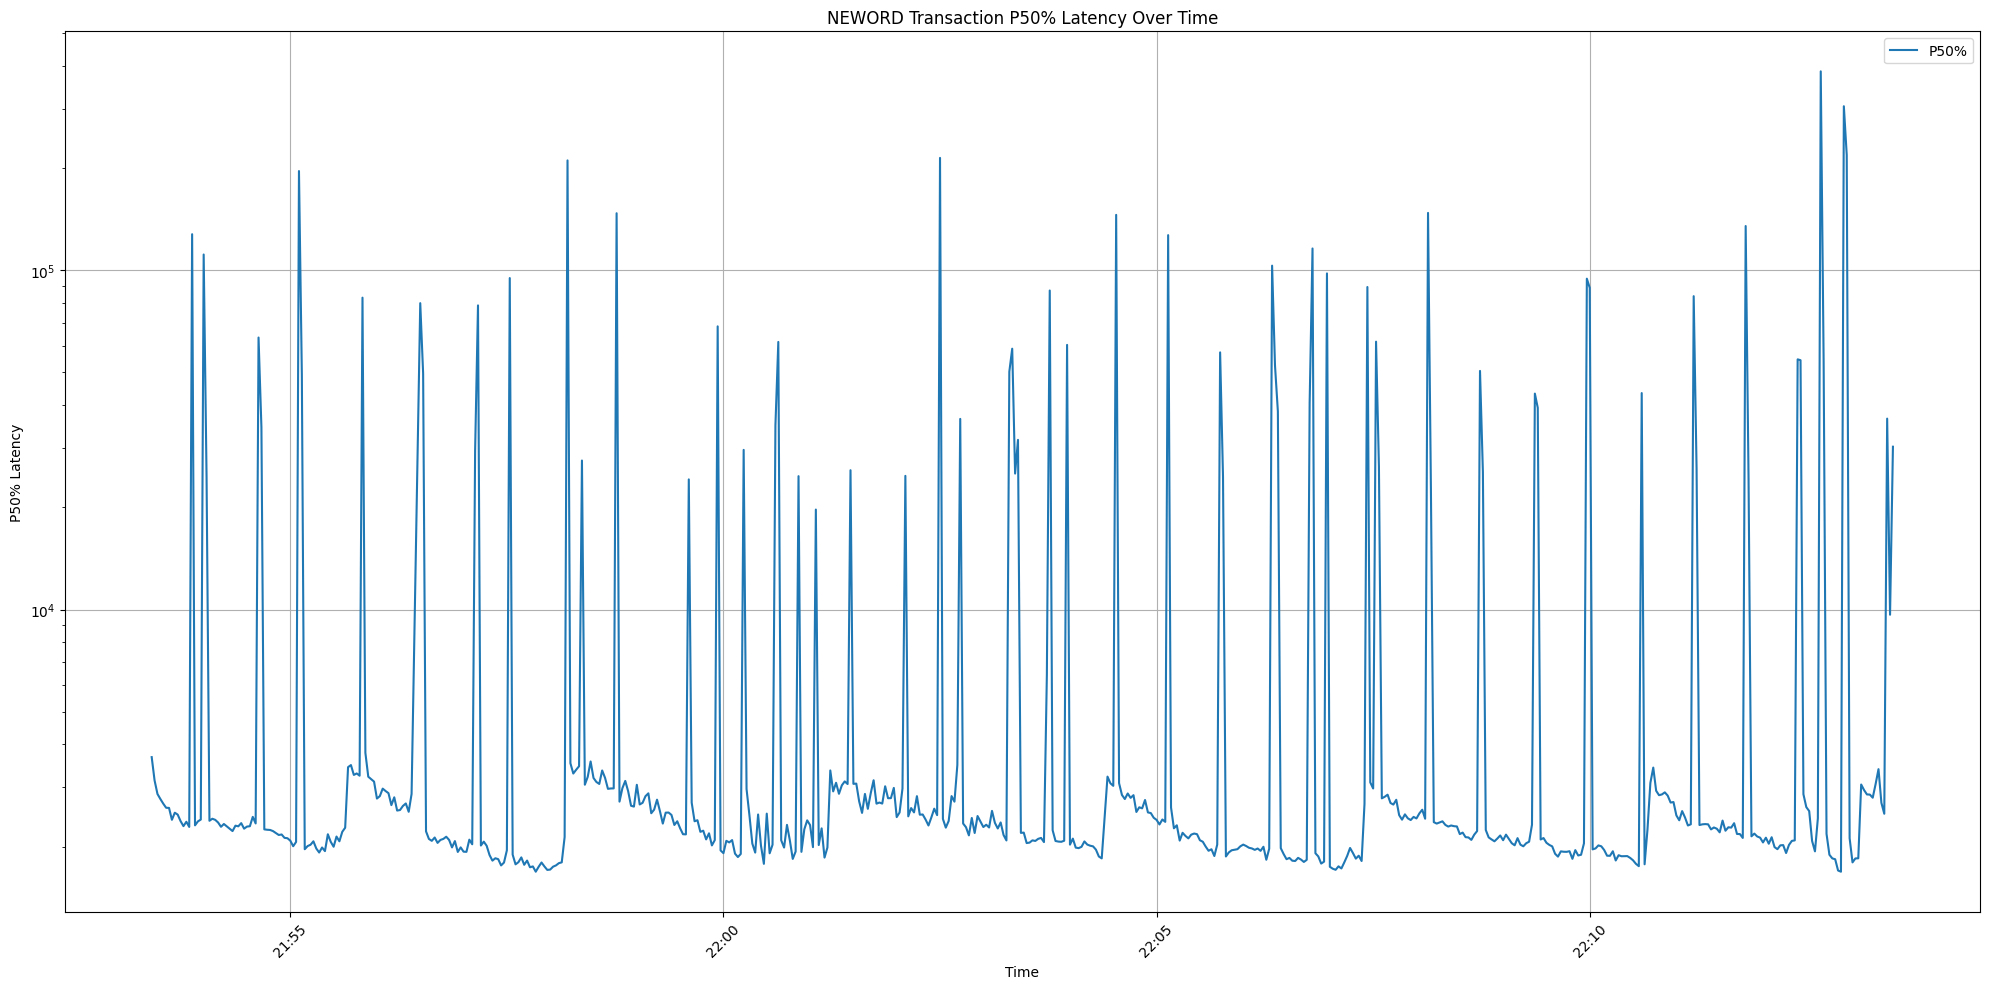

In [17]:
from matplotlib.pyplot import savefig
from numpy import save


trt_df = pd.read_csv('TRT/filtered_transaction_data.csv')
neword_df = trt_df[trt_df['Transaction_Type'] == 'NEWORD'].copy()
neword_df["Timestamp"] = pd.to_datetime(neword_df["Timestamp"], format="%H:%M:%S")

plt.figure(figsize=(20, 10))

plt.plot(neword_df["Timestamp"], neword_df["P50%"], label="P50%", linestyle="-")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.xticks(rotation=45)

plt.xlabel("Time")
plt.ylabel("P50% Latency")
plt.title("NEWORD Transaction P50% Latency Over Time")

plt.grid(True)

plt.yscale('log')
plt.tight_layout()

plt.legend()
plt.savefig("Plots/NEWORD_P50_Latency_Over_Time_Log.png")
plt.show()

#### NEWORD P50% Percentile in ms 

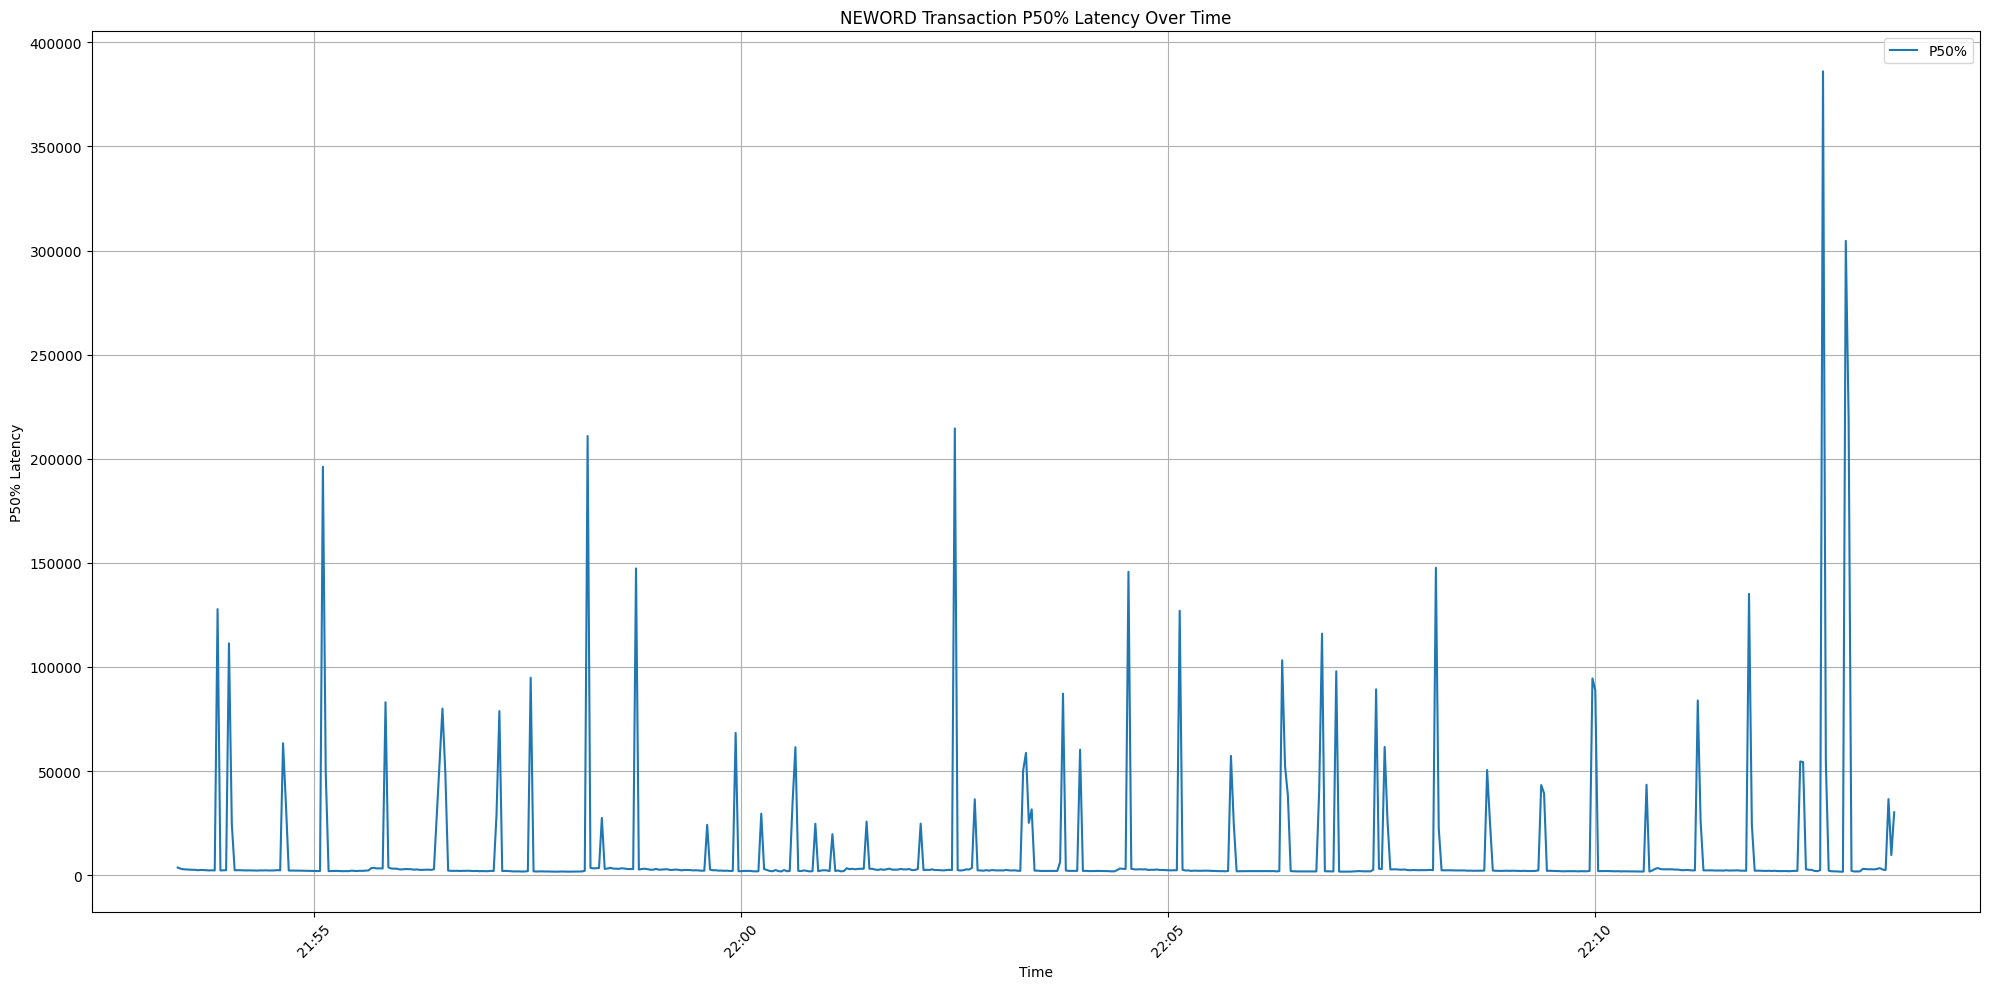

In [14]:
trt_df = pd.read_csv("TRT/filtered_transaction_data.csv")
neword_df = trt_df[trt_df["Transaction_Type"] == "NEWORD"].copy()
neword_df["Timestamp"] = pd.to_datetime(neword_df["Timestamp"], format="%H:%M:%S")

plt.figure(figsize=(20, 10))

plt.plot(neword_df["Timestamp"], neword_df["P50%"], label="P50%", linestyle="-")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.xticks(rotation=45)

plt.xlabel("Time")
plt.ylabel("P50% Latency")
plt.title("NEWORD Transaction P50% Latency Over Time")

plt.grid(True)

plt.tight_layout()

plt.legend()
plt.savefig('Plots/NEWORD_P50_Latency_Over_Time.png')
plt.show()

#### NEWORD P95% Percentile in ms

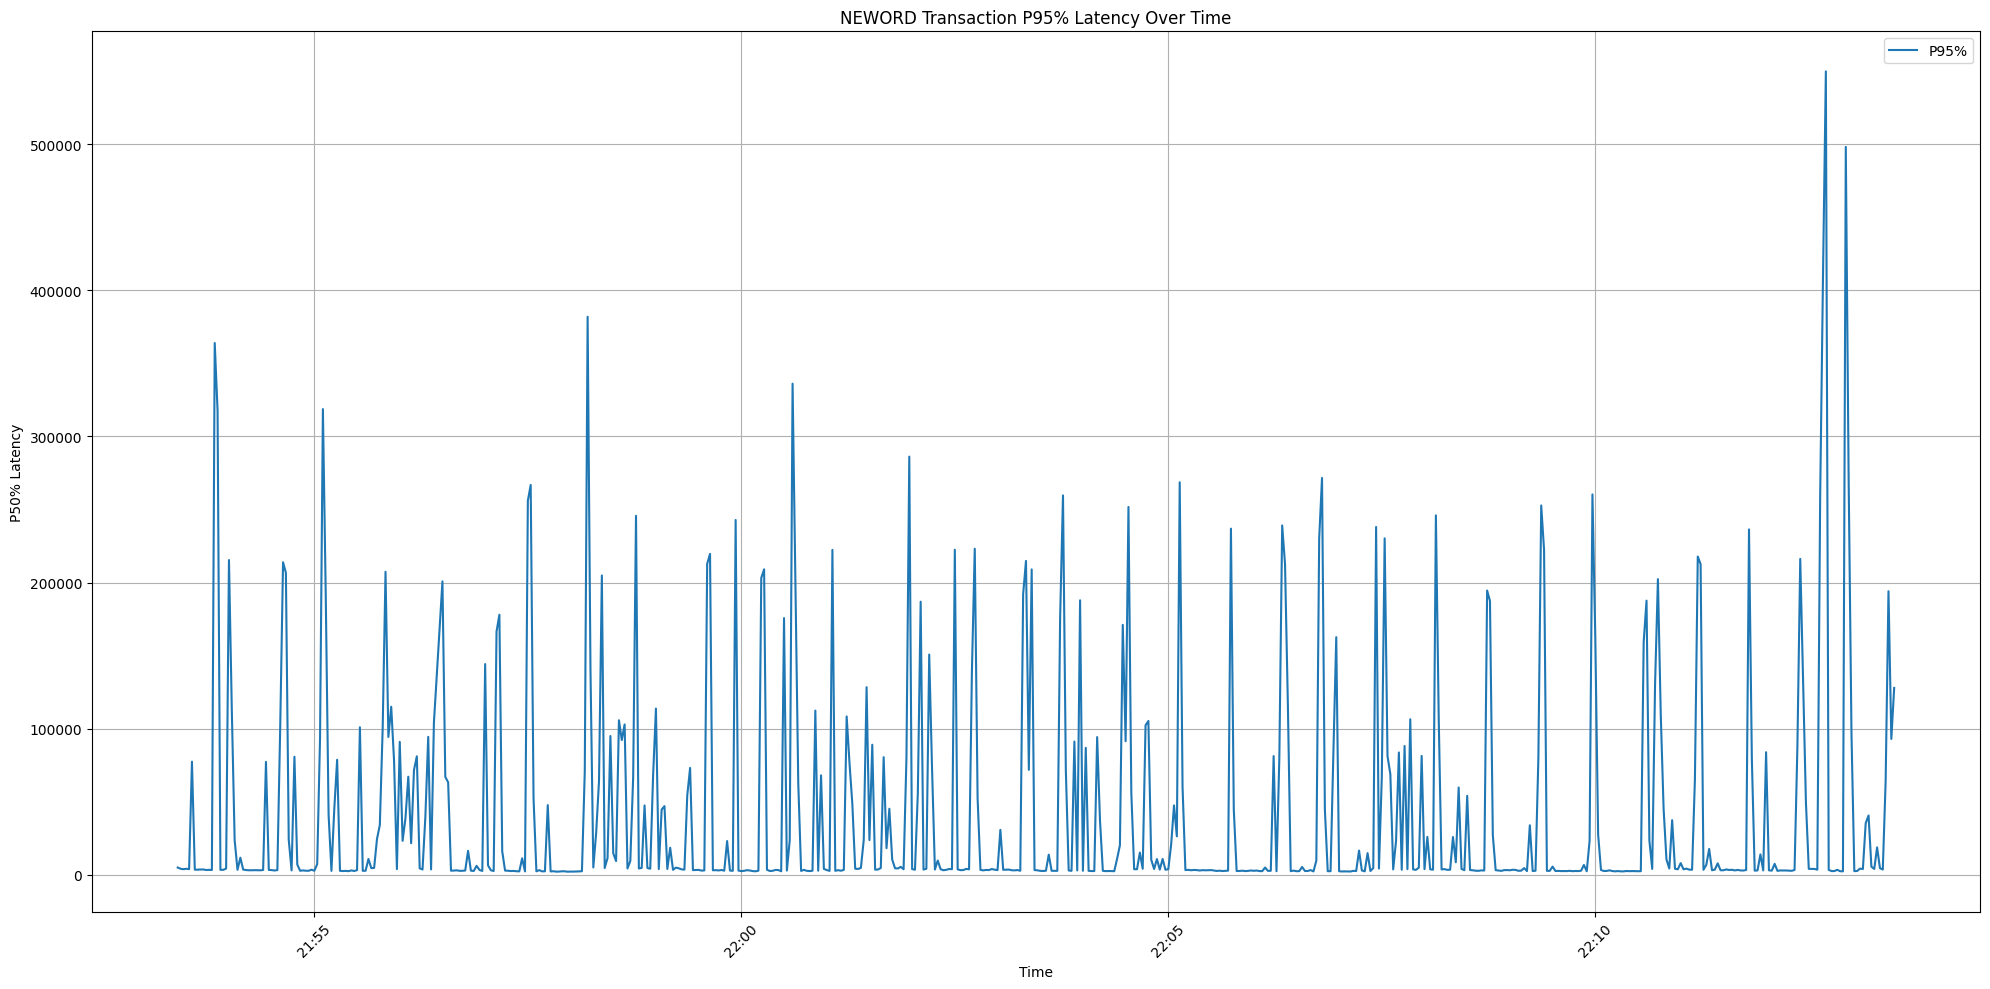

In [16]:
trt_df = pd.read_csv("TRT/filtered_transaction_data.csv")
neword_df = trt_df[trt_df["Transaction_Type"] == "NEWORD"].copy()
neword_df["Timestamp"] = pd.to_datetime(neword_df["Timestamp"], format="%H:%M:%S")

plt.figure(figsize=(20, 10))

plt.plot(neword_df["Timestamp"], neword_df["P95%"], label="P95%", linestyle="-")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.xticks(rotation=45)

plt.xlabel("Time")
plt.ylabel("P50% Latency")
plt.title("NEWORD Transaction P95% Latency Over Time")

plt.grid(True)

plt.tight_layout()

plt.legend()
plt.savefig('Plots/NEWORD_P95_Latency_Over_Time.png')
plt.show()

#### NEWORD P95% Percentile in ms on logarithmic scale

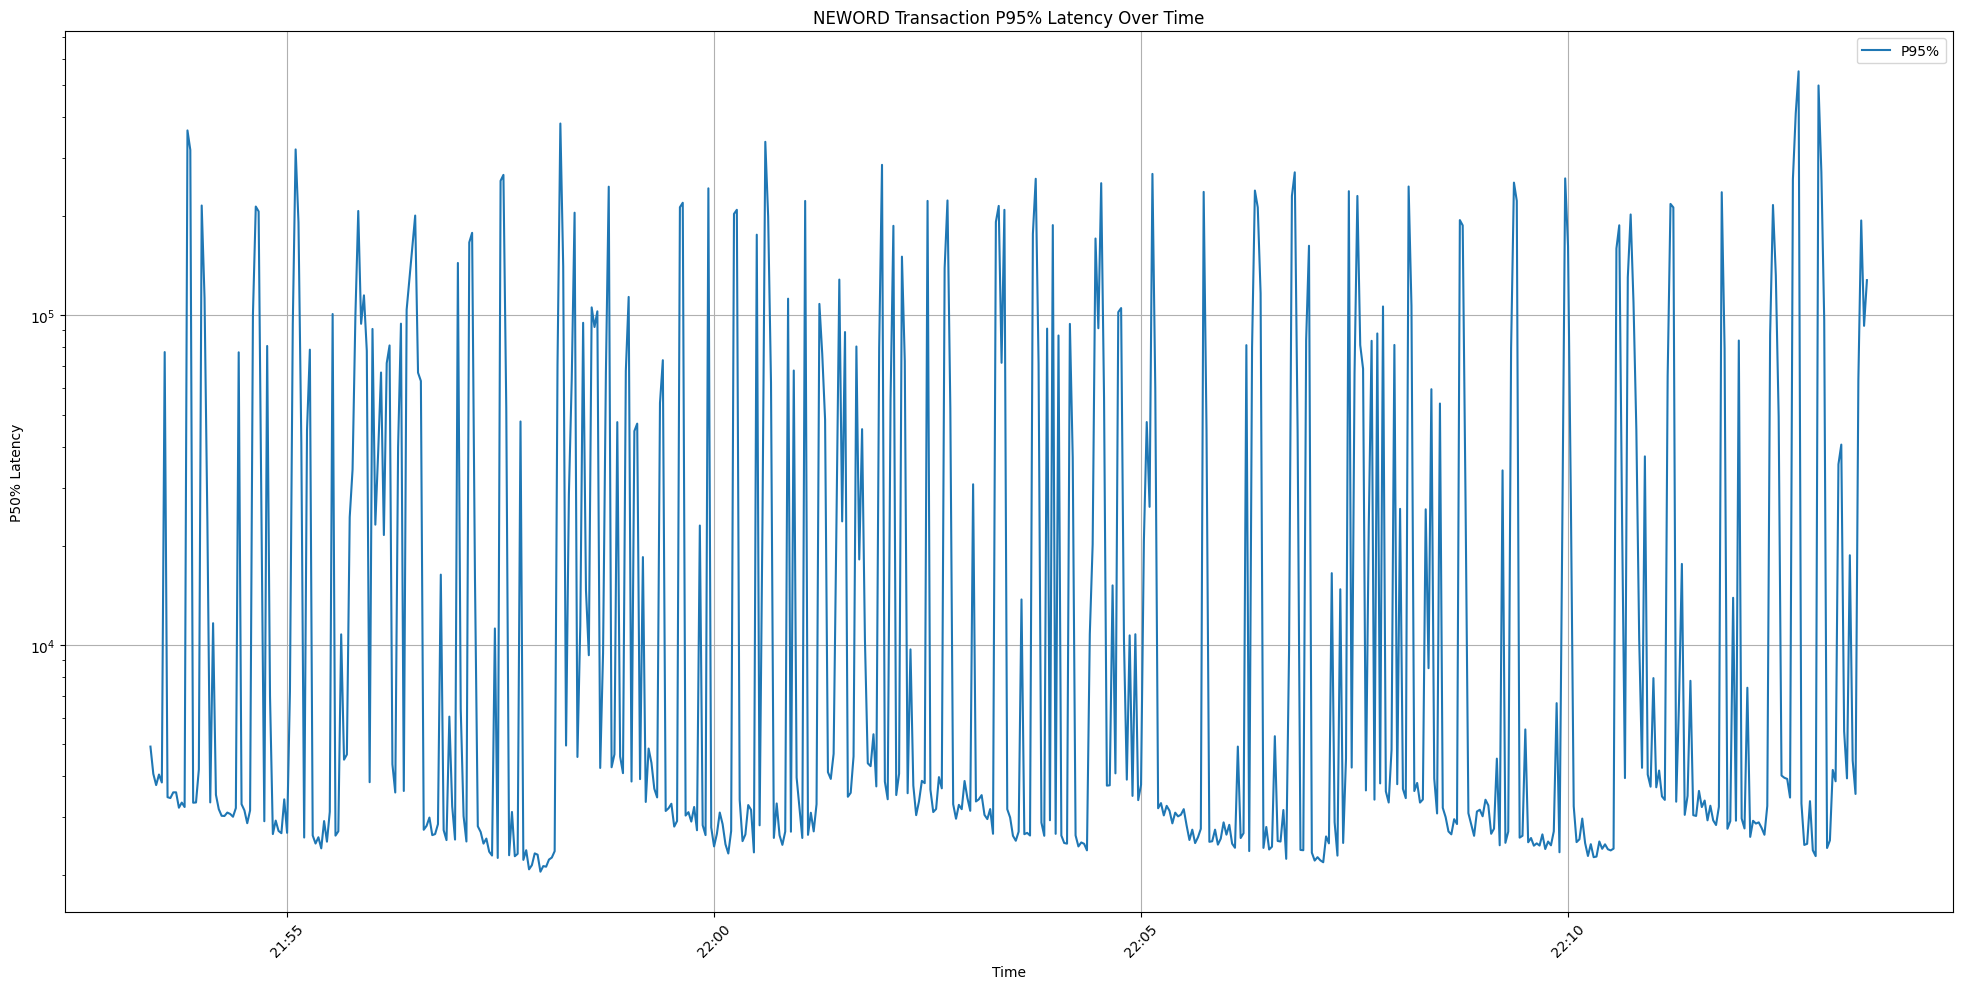

In [18]:
trt_df = pd.read_csv("TRT/filtered_transaction_data.csv")
neword_df = trt_df[trt_df["Transaction_Type"] == "NEWORD"].copy()
neword_df["Timestamp"] = pd.to_datetime(neword_df["Timestamp"], format="%H:%M:%S")

plt.figure(figsize=(20, 10))

plt.plot(neword_df["Timestamp"], neword_df["P95%"], label="P95%", linestyle="-")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.xticks(rotation=45)

plt.xlabel("Time")
plt.ylabel("P50% Latency")
plt.title("NEWORD Transaction P95% Latency Over Time")

plt.grid(True)

plt.tight_layout()

plt.yscale('log')

plt.legend()
plt.savefig('Plots/NEWORD_P95_Latency_Over_Time_Log.png')
plt.show()

## Statistical Analysis (only done for Metric: TRT (ms))

#### Slicing of time-series at known change points

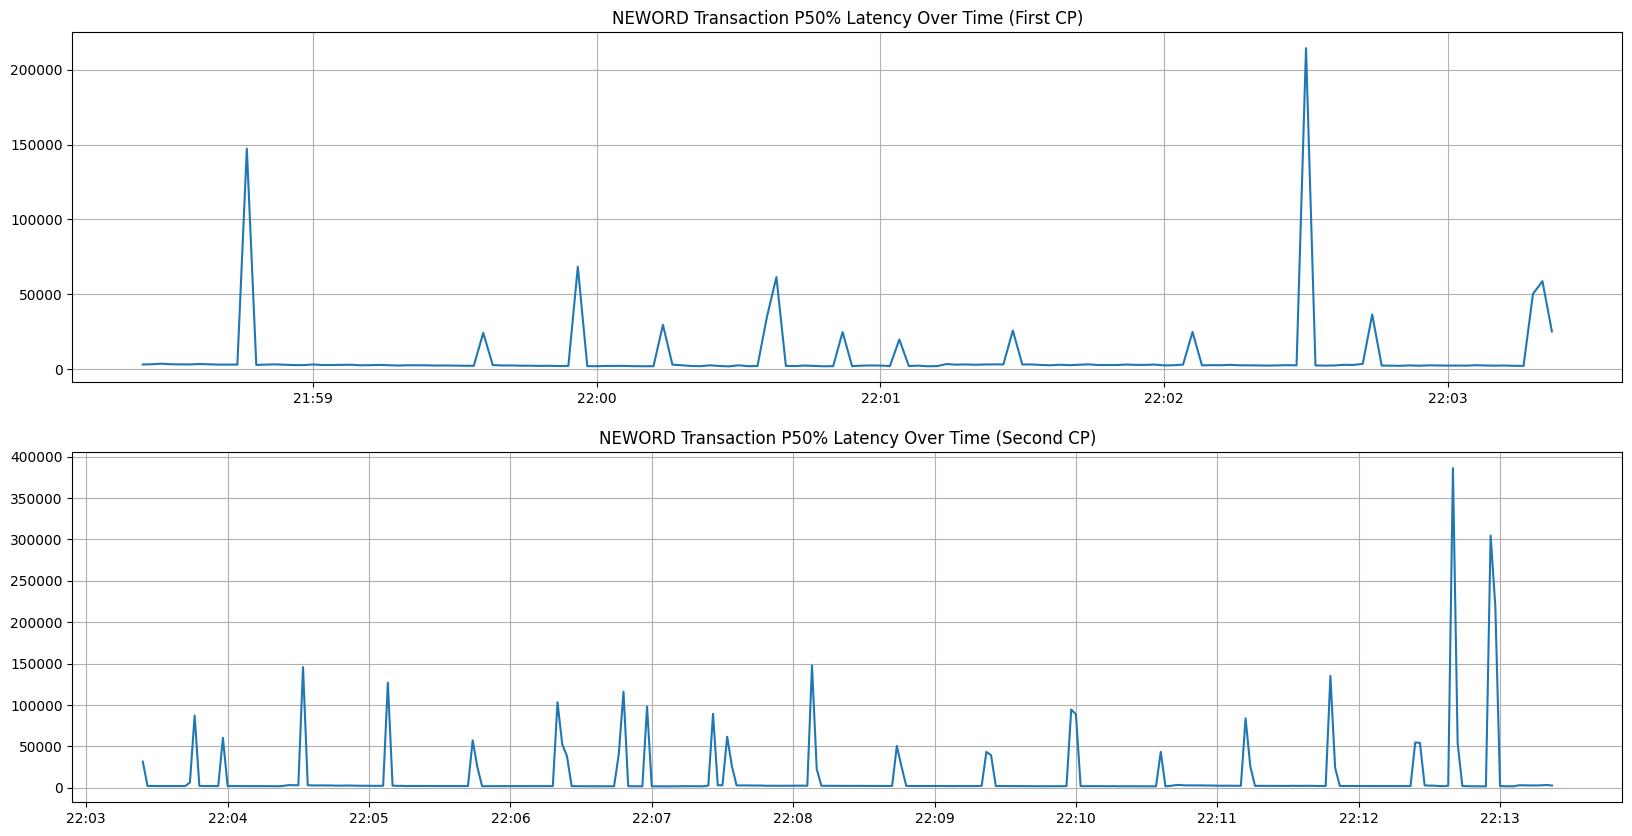

In [22]:
start_time = neword_df["Timestamp"].min()

df_firstCP = neword_df[(neword_df["Timestamp"] >= start_time + pd.Timedelta(minutes=5)) & (neword_df["Timestamp"] < start_time + pd.Timedelta(minutes=10))]
df_2ndCP = neword_df[(neword_df["Timestamp"] >= start_time + pd.Timedelta(minutes=10)) & (neword_df["Timestamp"] < start_time + pd.Timedelta(minutes=20))]

fig, axs = plt.subplots(2, 1, figsize=(20, 10))

# First Subplot
axs[0].plot(df_firstCP["Timestamp"], df_firstCP["P50%"], label="P50%", linestyle="-")
axs[0].set_title("NEWORD Transaction P50% Latency Over Time (First CP)")
axs[0].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
axs[0].xaxis.set_major_locator(mdates.AutoDateLocator())
axs[0].grid(True)
plt.savefig("Plots/NEWORD_P50_Latency_Over_Time_First_CP.png")

# Second Subplot
axs[1].plot(df_2ndCP["Timestamp"], df_2ndCP["P50%"], label="P50%", linestyle="-")
axs[1].set_title("NEWORD Transaction P50% Latency Over Time (Second CP)")
axs[1].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
axs[1].xaxis.set_major_locator(mdates.AutoDateLocator())
axs[1].grid(True)
plt.savefig("Plots/NEWORD_P50_Latency_Over_Time_Second_CP.png")

#### Calculating mean, variance and standard deviation of time-series before and after change points 

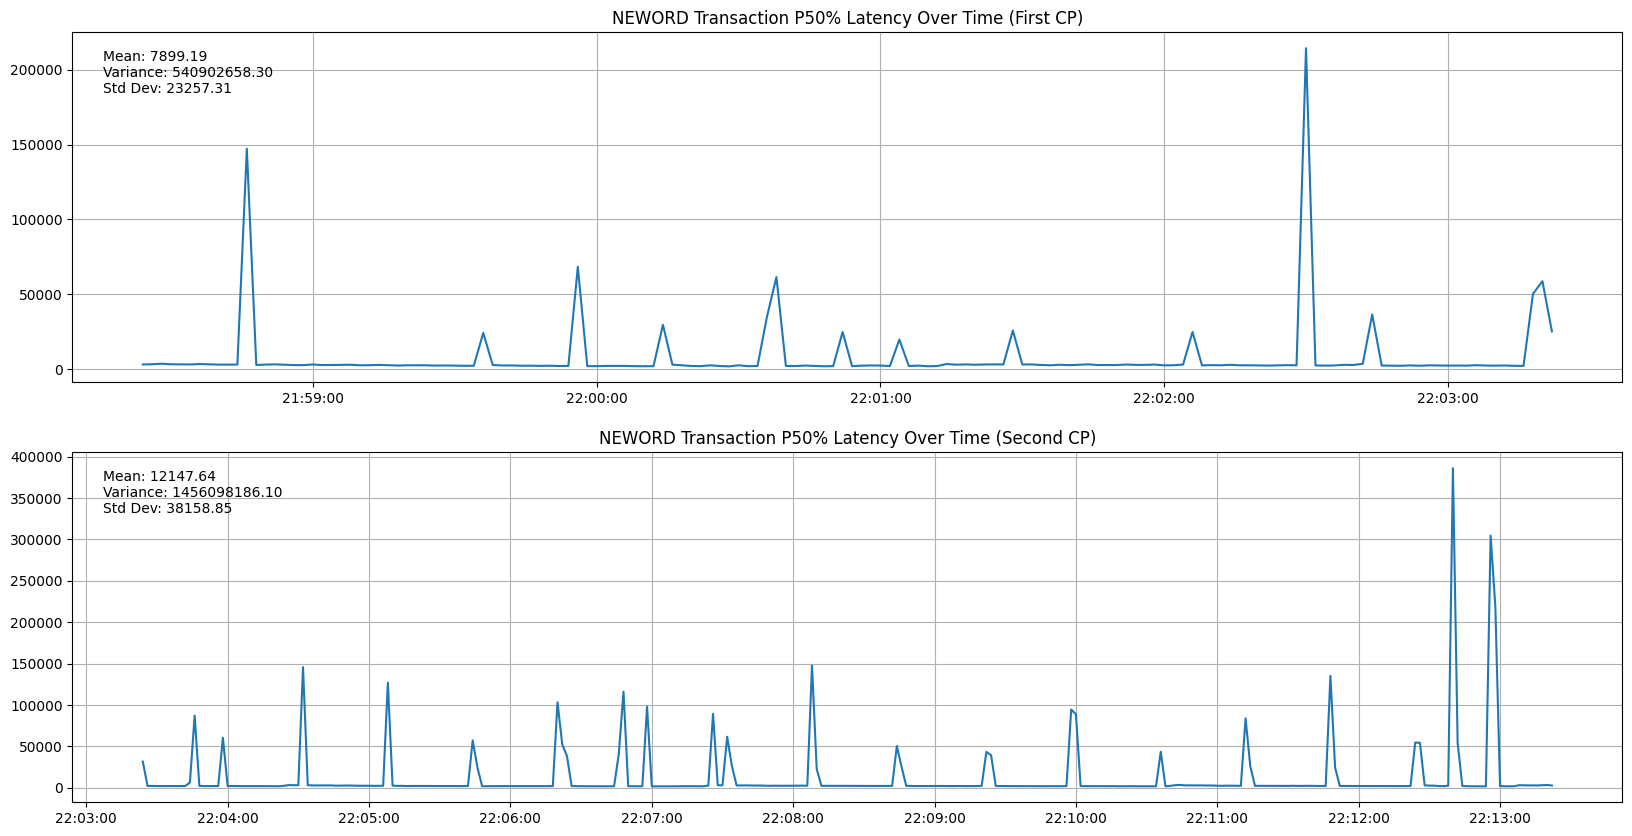

In [24]:
start_time = neword_df["Timestamp"].min()

df_firstCP = neword_df[
    (neword_df["Timestamp"] >= start_time + pd.Timedelta(minutes=5, seconds=0)) # Erster Plot startet nach 5 Minuten des Runs (dann beginnt exhaustor)
    & (neword_df["Timestamp"] < start_time + pd.Timedelta(minutes=10, seconds=0)) # Plot zeigt demnach den Zeitraum, in dem exhaustor läuft
]
df_2ndCP = neword_df[
    (neword_df["Timestamp"] >= start_time + pd.Timedelta(minutes=10, seconds=0)) # Zweiter Plot startet nach 10 Minuten des Runs, also wenn exhaustor wieder inaktiv ist
    & (neword_df["Timestamp"] < start_time + pd.Timedelta(minutes=20, seconds=0)) # Plot nimmt Zeitraum bis Ende des Benchmark Runs auf
]

fig, axs = plt.subplots(2, 1, figsize=(20, 10))

# First Subplot
axs[0].plot(df_firstCP["Timestamp"], df_firstCP["P50%"], label="P50%", linestyle="-")
axs[0].set_title("NEWORD Transaction P50% Latency Over Time (First CP)")
axs[0].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S")) 
axs[0].xaxis.set_major_locator(mdates.AutoDateLocator())
axs[0].grid(True)
plt.savefig("Plots/NEWORD_P50_Latency_Over_Time_First_CP_values.png")

# Stats 1
mean = df_firstCP["P50%"].mean()
variance = df_firstCP["P50%"].var()
std_dev = df_firstCP["P50%"].std()
axs[0].text(0.02, 0.95, f'Mean: {mean:.2f}\nVariance: {variance:.2f}\nStd Dev: {std_dev:.2f}', transform=axs[0].transAxes, verticalalignment='top')


# Second Subplot
axs[1].plot(df_2ndCP["Timestamp"], df_2ndCP["P50%"], label="P50%", linestyle="-")
axs[1].set_title("NEWORD Transaction P50% Latency Over Time (Second CP)")
axs[1].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S")) 
axs[1].xaxis.set_major_locator(mdates.AutoDateLocator())
axs[1].grid(True)

# Stats 2
mean = df_2ndCP["P50%"].mean()
variance = df_2ndCP["P50%"].var()
std_dev = df_2ndCP["P50%"].std()
axs[1].text(0.02, 0.95, f'Mean: {mean:.2f}\nVariance: {variance:.2f}\nStd Dev: {std_dev:.2f}', transform=axs[1].transAxes, verticalalignment='top')
plt.savefig("Plots/NEWORD_P50_Latency_Over_Time_Second_CP_values.png")

## CPD

#### PELT

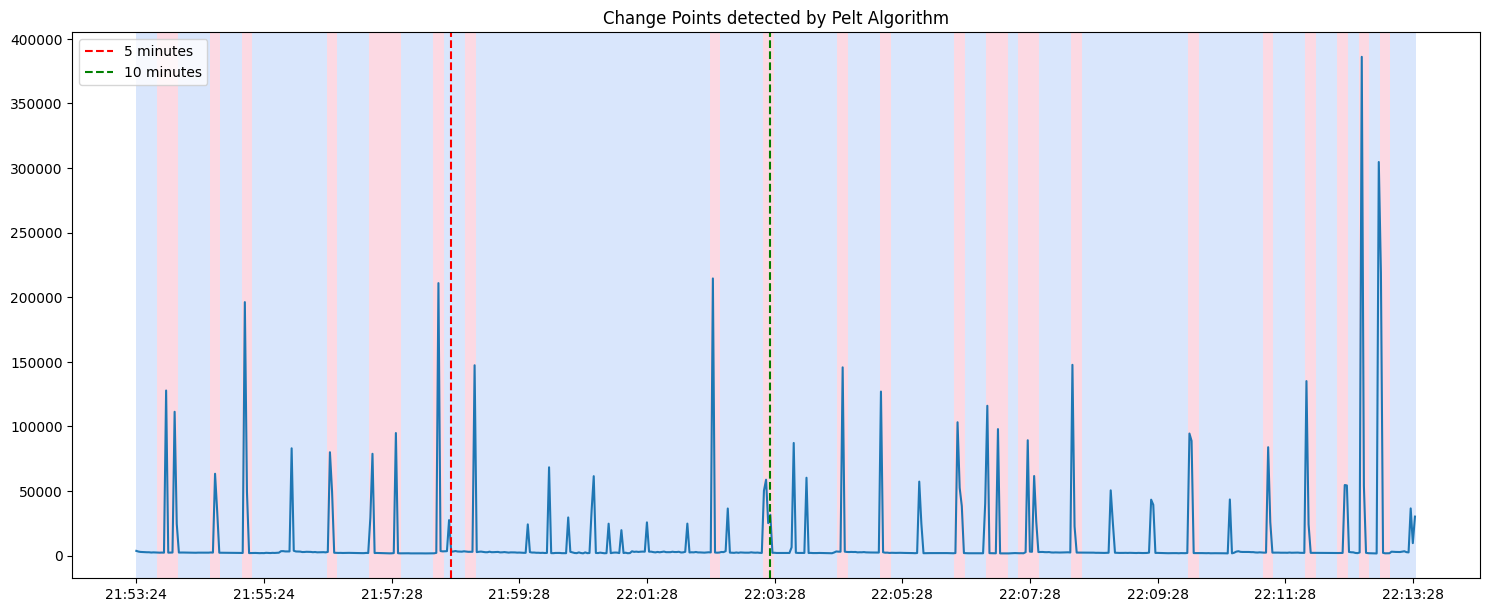

In [25]:
neword_df = trt_df[trt_df["Transaction_Type"] == "NEWORD"].copy()
neword_df["Timestamp"] = pd.to_datetime(neword_df["Timestamp"], format="%H:%M:%S")

start_time = neword_df["Timestamp"].iloc[0]

five_minutes = (start_time + pd.Timedelta(minutes=5)).time()
ten_minutes = (start_time + pd.Timedelta(minutes=10)).time()

# Modeling
signal = neword_df["P50%"].values
model = "l2"
algo = rpt.Pelt(model=model).fit(signal)
result = algo.predict(pen=700000000)

rpt.display(signal, result, figsize=(15, 6))

for i, timestamp in enumerate(neword_df["Timestamp"]):
    if timestamp.time() >= five_minutes:
        plt.axvline(x=i, color="r", linestyle="--", label="5 minutes")
        break

for i, timestamp in enumerate(neword_df["Timestamp"]):
    if timestamp.time() >= ten_minutes:
        plt.axvline(x=i, color="g", linestyle="--", label="10 minutes")
        break

plt.xticks(ticks=range(0, len(signal), len(signal) // 10),labels=neword_df["Timestamp"].dt.time.astype(str).values[:: len(signal) // 10],)

plt.legend()
plt.title("Change Points detected by Pelt Algorithm")
plt.savefig("Plots/Change_Points_Pelt_Algorithm.png")
plt.show()

#### DP (with know and unknown change points passed as argument)

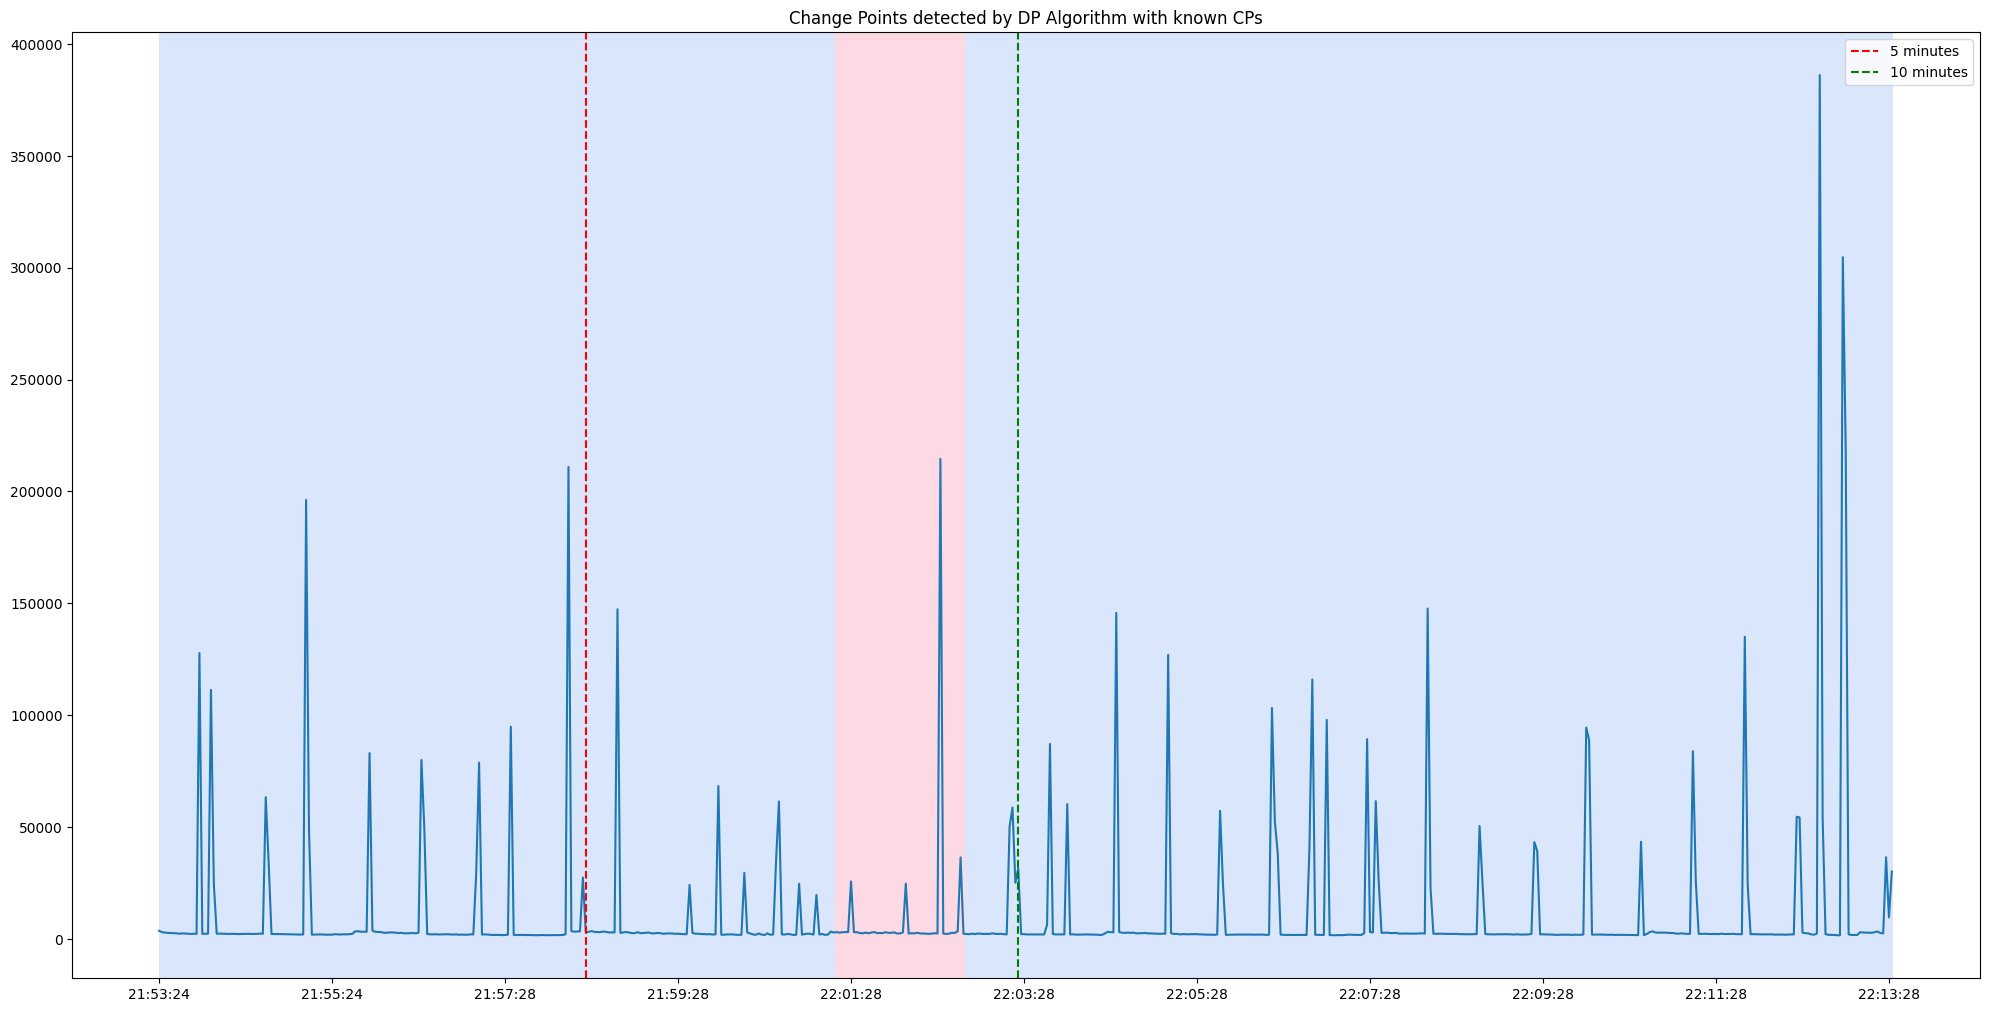

In [27]:
trt_df = pd.read_csv("TRT/filtered_transaction_data.csv")
neword_df = trt_df[trt_df["Transaction_Type"] == "NEWORD"].copy()
neword_df["Timestamp"] = pd.to_datetime(neword_df["Timestamp"], format="%H:%M:%S")

# Modeling
signal = neword_df["P50%"].values
model = "rbf"  # euclidean distance
algo = rpt.Dynp(model=model, min_size=1, jump=5).fit(signal)
result = algo.predict(n_bkps=2)

rpt.display(signal, result, figsize=(20, 10))

for i, timestamp in enumerate(neword_df["Timestamp"]):
    if timestamp.time() >= five_minutes:
        plt.axvline(x=i, color="r", linestyle="--", label="5 minutes")
        break

for i, timestamp in enumerate(neword_df["Timestamp"]):
    if timestamp.time() >= ten_minutes:
        plt.axvline(x=i, color="g", linestyle="--", label="10 minutes")
        break

plt.xticks(ticks=range(0, len(signal), len(signal) // 10),labels=neword_df["Timestamp"].dt.time.astype(str).values[:: len(signal) // 10],)

plt.legend()
plt.title("Change Points detected by DP Algorithm with known CPs")
plt.savefig("Plots/Change_Points_DP_Algorithm.png")
plt.show()

# Metric: SYS-resources (CPU & memory)

## PreProcessing

#### CPU usage (%) on logarithmic scale

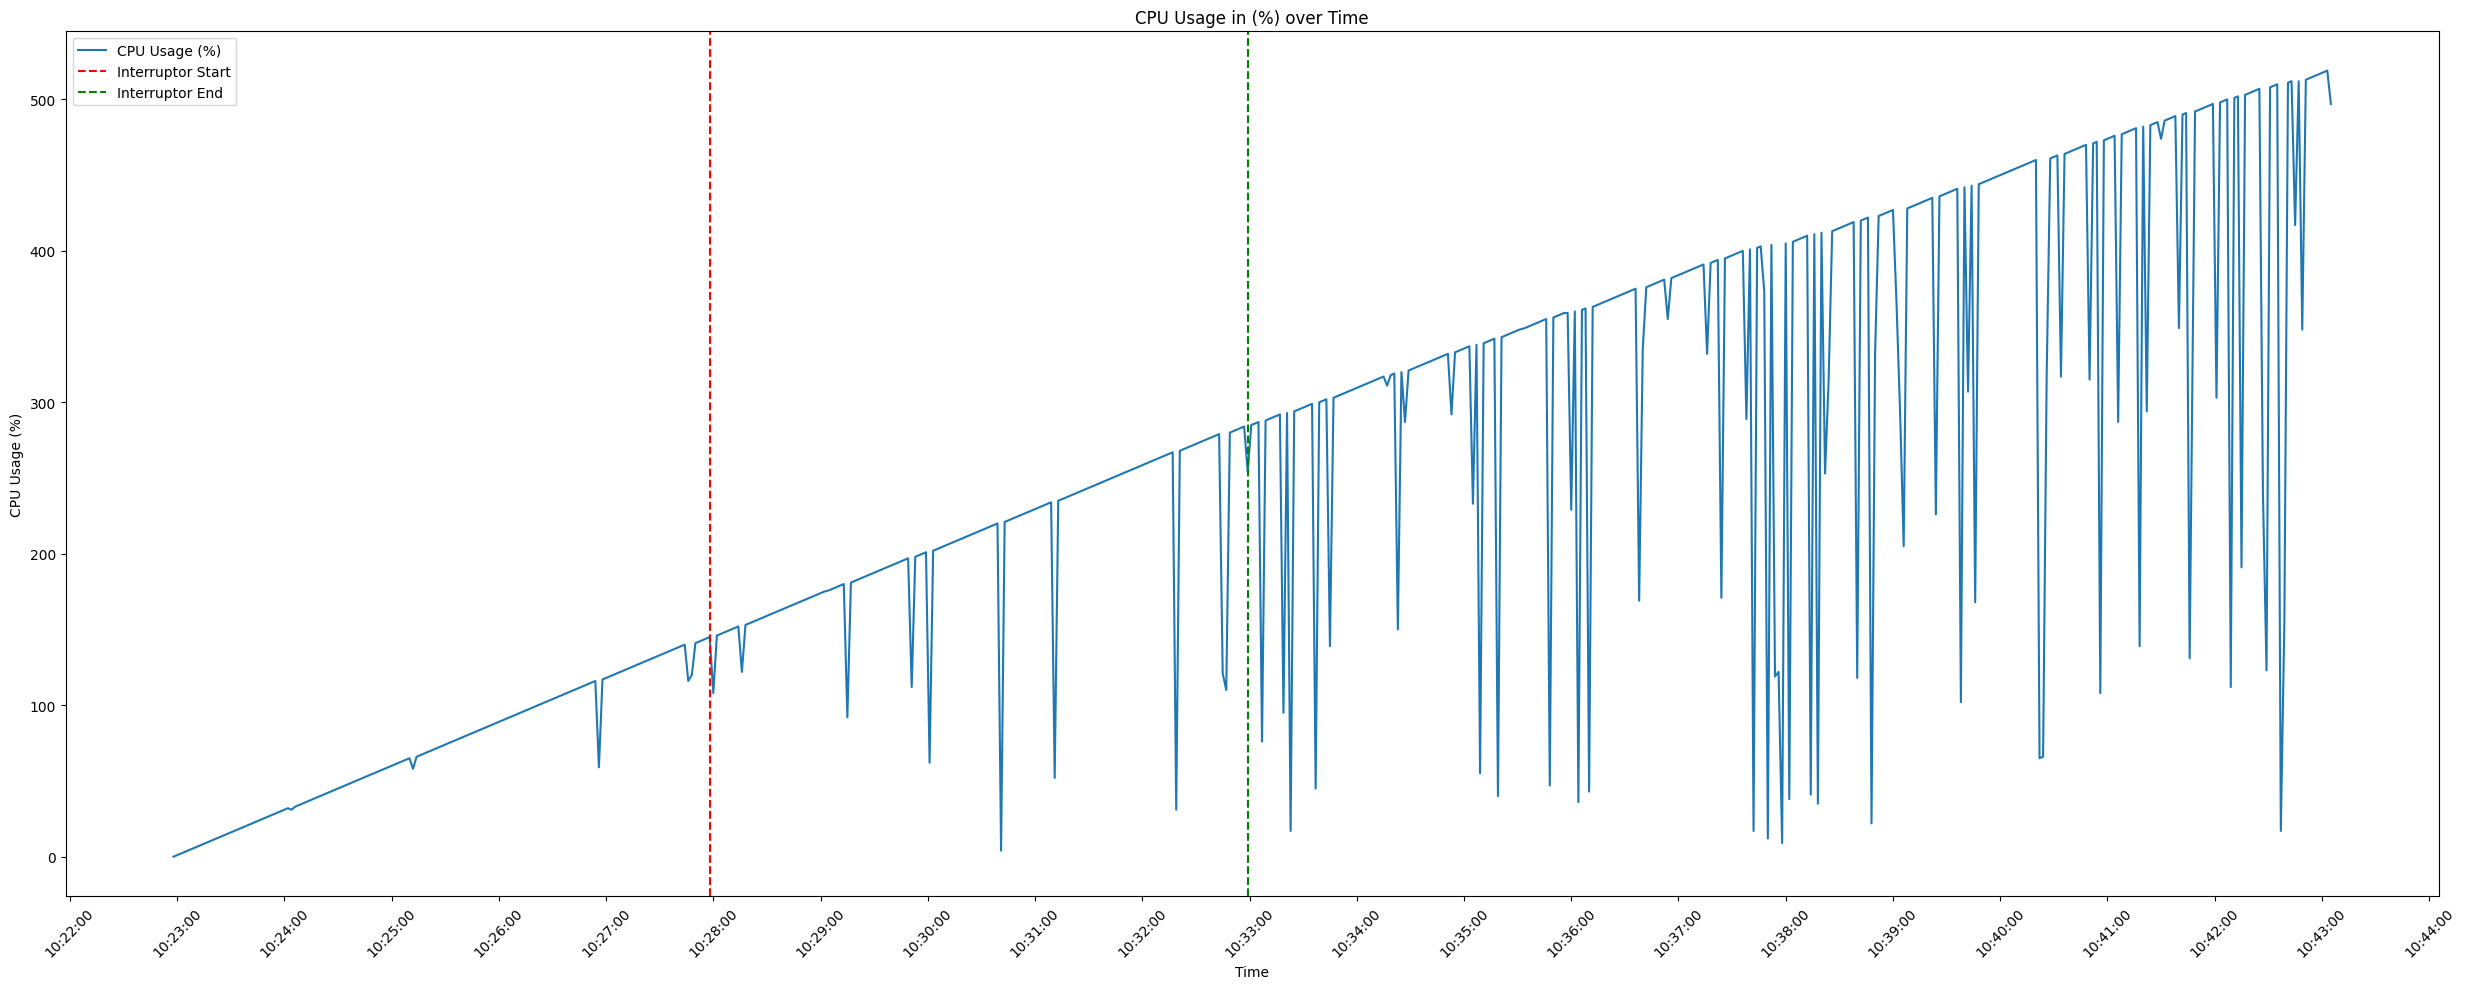

In [69]:
df = pd.read_csv("SYS/docker_container_stats.csv")

df.columns = df.columns.str.strip()

df['CPU Usage (%)'] = df['CPU Usage (%)'].str.rstrip('%')
df['Time'] = pd.to_datetime(df['Time'])

cpu_df = df[['Time', 'CPU Usage (%)']].copy()

# print(cpu_df.head(5))

plt.figure(figsize=(25, 10))

plt.plot(cpu_df["Time"], cpu_df["CPU Usage (%)"], linestyle="-", label="CPU Usage (%)")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

start_time = cpu_df["Time"].min()
time_5min = start_time + pd.Timedelta(minutes=5)

exact_time_5min = cpu_df.iloc[(cpu_df["Time"] - time_5min).abs().argsort()[:1]]["Time"].values[0]
exact_time_10min = cpu_df.iloc[(cpu_df["Time"] - (start_time + pd.Timedelta(minutes=10))).abs().argsort()[:1]]["Time"].values[0]

plt.axvline(x=exact_time_5min, color="r", linestyle="--", label="Interruptor Start")
plt.axvline(x=exact_time_10min, color="g", linestyle="--", label="Interruptor End")
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))


plt.xlabel("Time")
plt.ylabel("CPU Usage (%)")
plt.title("CPU Usage in (%) over Time")

# plt.grid(True)

plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=1))

plt.tight_layout()

plt.yscale("linear")

plt.legend()
plt.savefig("SYS/Plots/CPU_Usage_Over_Time_Log.png")
plt.show()

#### Memory usage (%)

                 Time         Memory Usage
0 2024-03-12 10:22:58  582.5MiB / 31.34GiB
1 2024-03-12 10:23:00  600.8MiB / 31.34GiB
2 2024-03-12 10:23:02  611.8MiB / 31.34GiB
3 2024-03-12 10:23:04  624.1MiB / 31.34GiB
4 2024-03-12 10:23:06  631.4MiB / 31.34GiB


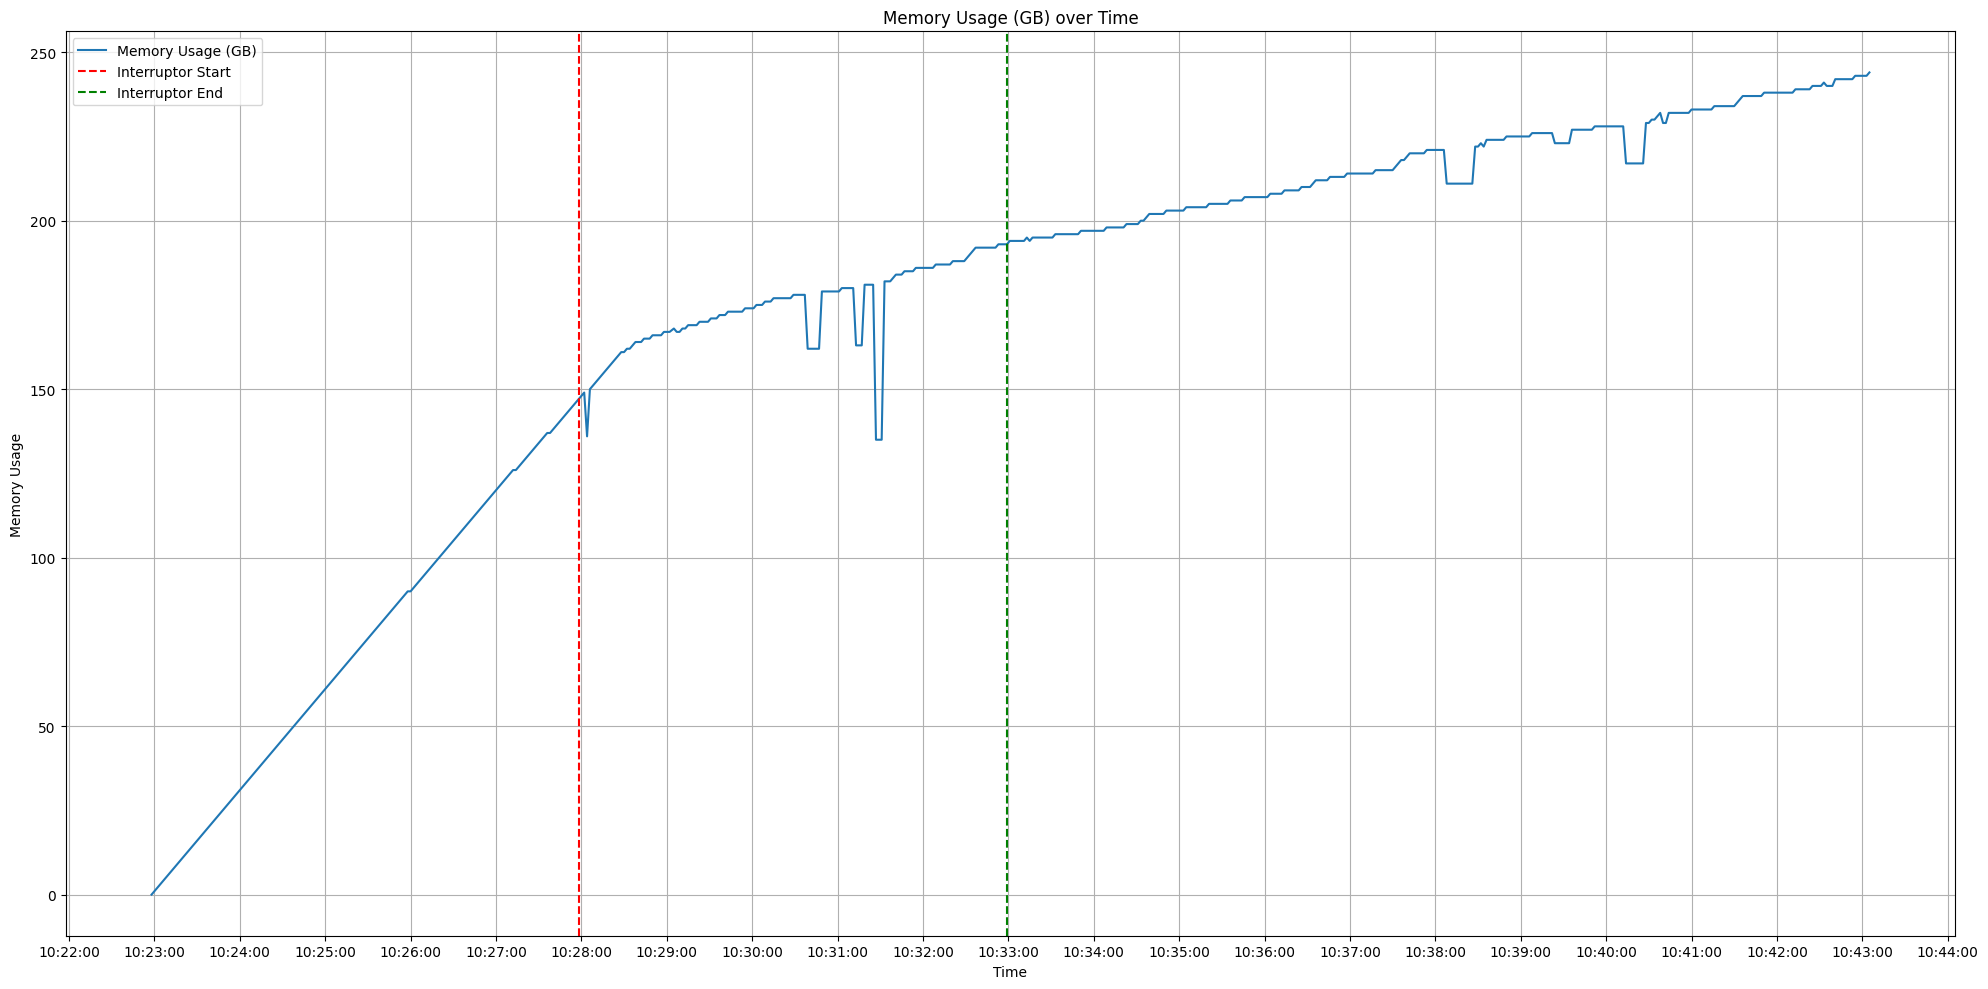

In [64]:
df = pd.read_csv("SYS/docker_container_stats.csv")
df.columns = df.columns.str.strip()

df["Memory Usage"] = (df["Memory Usage"])
df["Time"] = pd.to_datetime(df["Time"])

mem_df = df[["Time", "Memory Usage"]].copy()

print(mem_df.head(5))

start = mem_df["Time"].min()
time_5 = start + pd.Timedelta(minutes=5)
time_10 = start + pd.Timedelta(minutes=10)

exact_time_5min = mem_df.iloc[(mem_df["Time"] - time_5).abs().argsort()[:1]].iloc[0]["Time"]
exact_time_10min = mem_df.iloc[(mem_df["Time"] - time_10).abs().argsort()[:1]].iloc[0]["Time"]

plt.figure(figsize=(20, 10))

plt.plot(mem_df["Time"], mem_df["Memory Usage"], linestyle="-", label="Memory Usage (GB)")

plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))

plt.xlabel("Time")
plt.ylabel("Memory Usage")
plt.title("Memory Usage (GB) over Time")

plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=1))

plt.axvline(x=exact_time_5min, color="r", linestyle="--", label="Interruptor Start")
plt.axvline(x=exact_time_10min, color="g", linestyle="--", label="Interruptor End")

plt.grid(True)
plt.yscale("linear")
plt.legend()
plt.tight_layout()
plt.savefig("SYS/Plots/Memory_Usage_Over_Time.png")
plt.show()

## CPD

#### PELT for memory usage

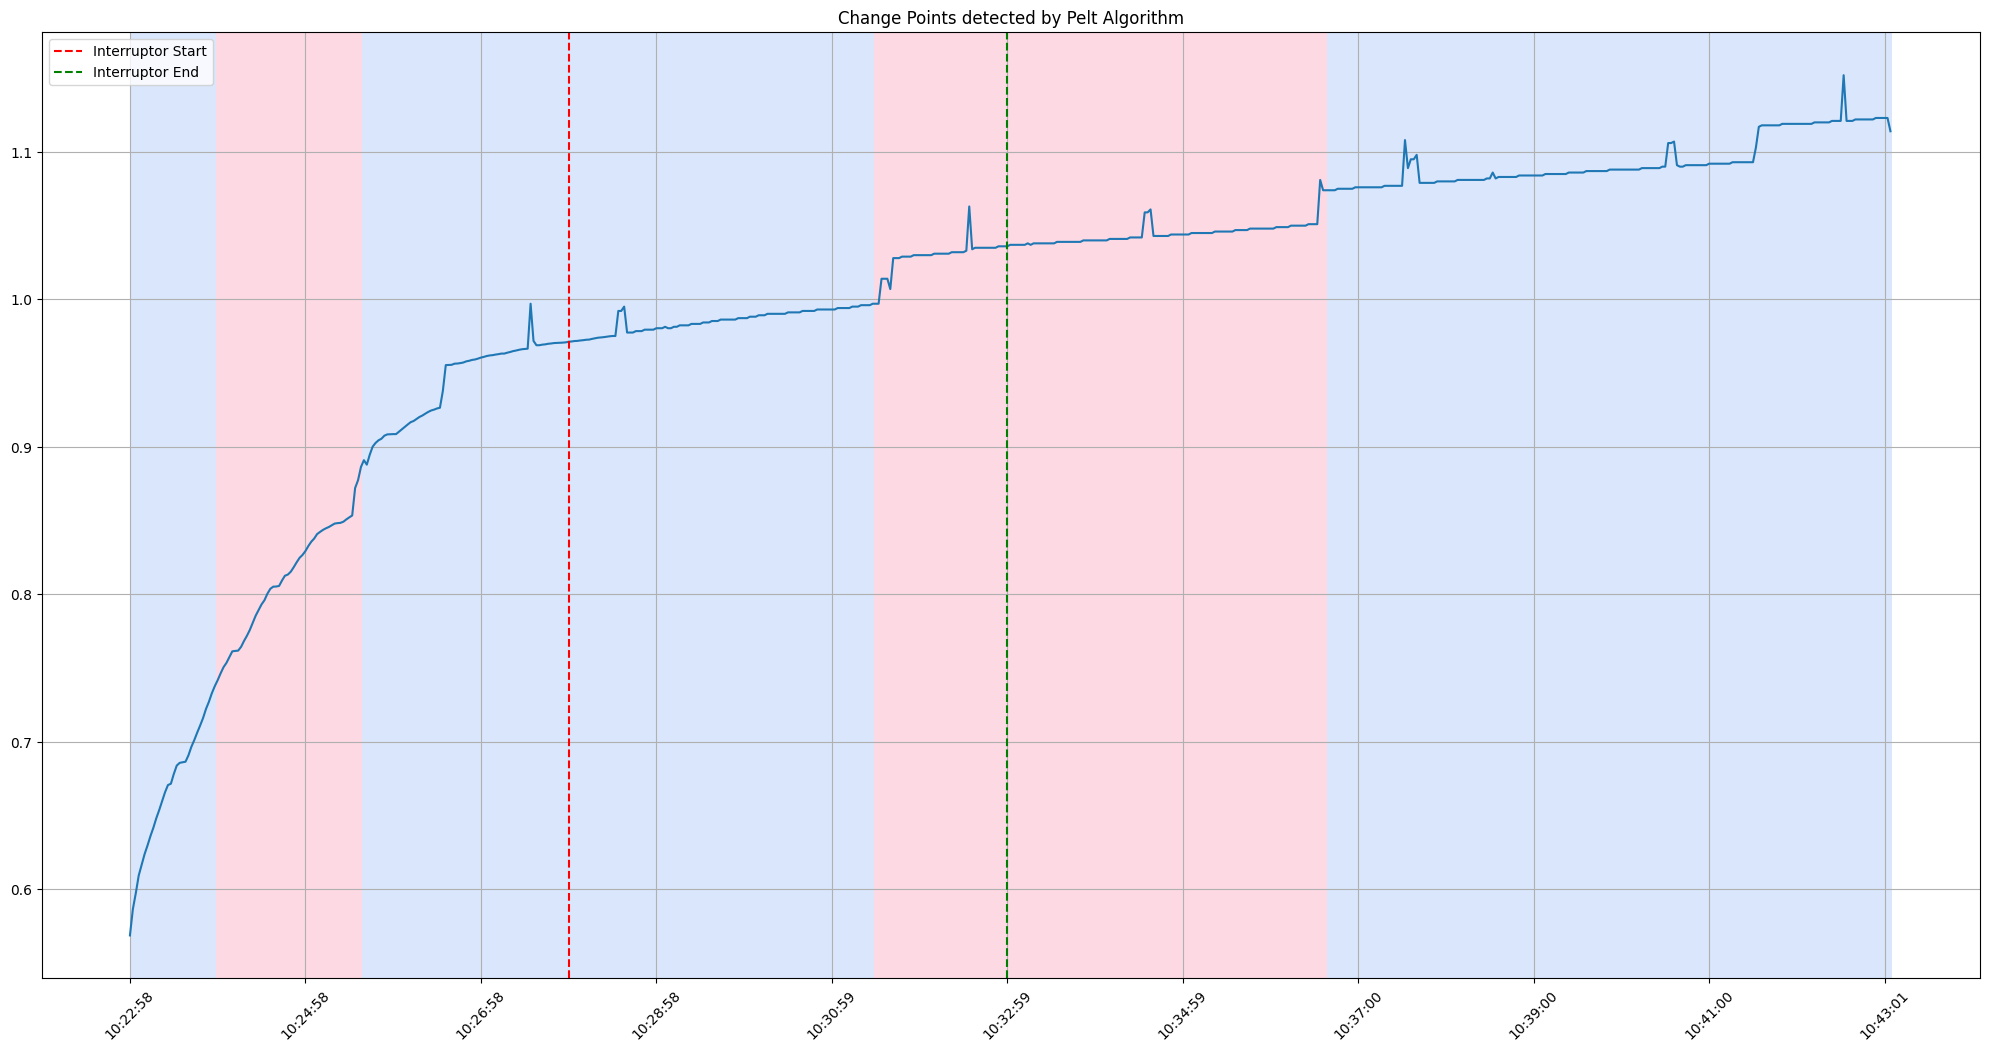

In [96]:
df = pd.read_csv("SYS/docker_container_stats.csv")
df.columns = df.columns.str.strip()

# df["Memory Usage"] = (df["Memory Usage"].str.replace("MiB", "").str.replace("GiB", "").str.strip())
df["Memory Usage"] = df["Memory Usage"].str.split("/").str[0]
df["Memory Usage"] = df["Memory Usage"].apply(lambda x: (pd.to_numeric(x.replace("MiB", "")) / 1024 if "MiB" in x else pd.to_numeric(x.replace("GiB", ""))))

# df["Memory Usage"] = pd.to_numeric(df["Memory Usage"])

df["Time"] = pd.to_datetime(df["Time"], format="%Y-%m-%d %H:%M:%S")

mem_df = df[["Time", "Memory Usage"]].copy()

time_labels = mem_df["Time"].dt.strftime("%H:%M:%S").values
indices = np.arange(len(signal))

start = mem_df["Time"].min()
time_5 = start + pd.Timedelta(minutes=5)
time_10 = start + pd.Timedelta(minutes=10)

exact_time_5min = mem_df.iloc[(mem_df["Time"] - time_5).abs().argsort()[:1]].iloc[0]["Time"]
exact_time_10min = mem_df.iloc[(mem_df["Time"] - time_10).abs().argsort()[:1]].iloc[0]["Time"]

model = "l2"  # "l1", "rbf" # Try with different models and compare results

signal = mem_df["Memory Usage"].values

algo = rpt.Pelt(model=model).fit(signal)

result = algo.predict(pen=0.2)

# Using ruptures display function
rpt.display(signal, result, figsize=(20, 10))
step_size = len(signal) // 10 if len(signal) // 10 > 0 else 1

indices = np.arange(0, len(signal), step_size)
time_labels = mem_df["Time"].dt.strftime("%H:%M:%S").values[indices]
plt.xticks(ticks=indices, labels=time_labels, rotation=45)
index_5min = mem_df[mem_df["Time"] == exact_time_5min].index[0]
index_10min = mem_df[mem_df["Time"] == exact_time_10min].index[0]

plt.axvline(x=index_5min, color="r", linestyle="--", label="Interruptor Start")
plt.axvline(x=index_10min, color="g", linestyle="--", label="Interruptor End")

plt.legend()
plt.title("Change Points detected by Pelt Algorithm")
plt.grid(True)
plt.savefig("SYS/Plots/Change_Points_Pelt_Algorithm_mem.png")
plt.show()

#### Pelt for cpu usage

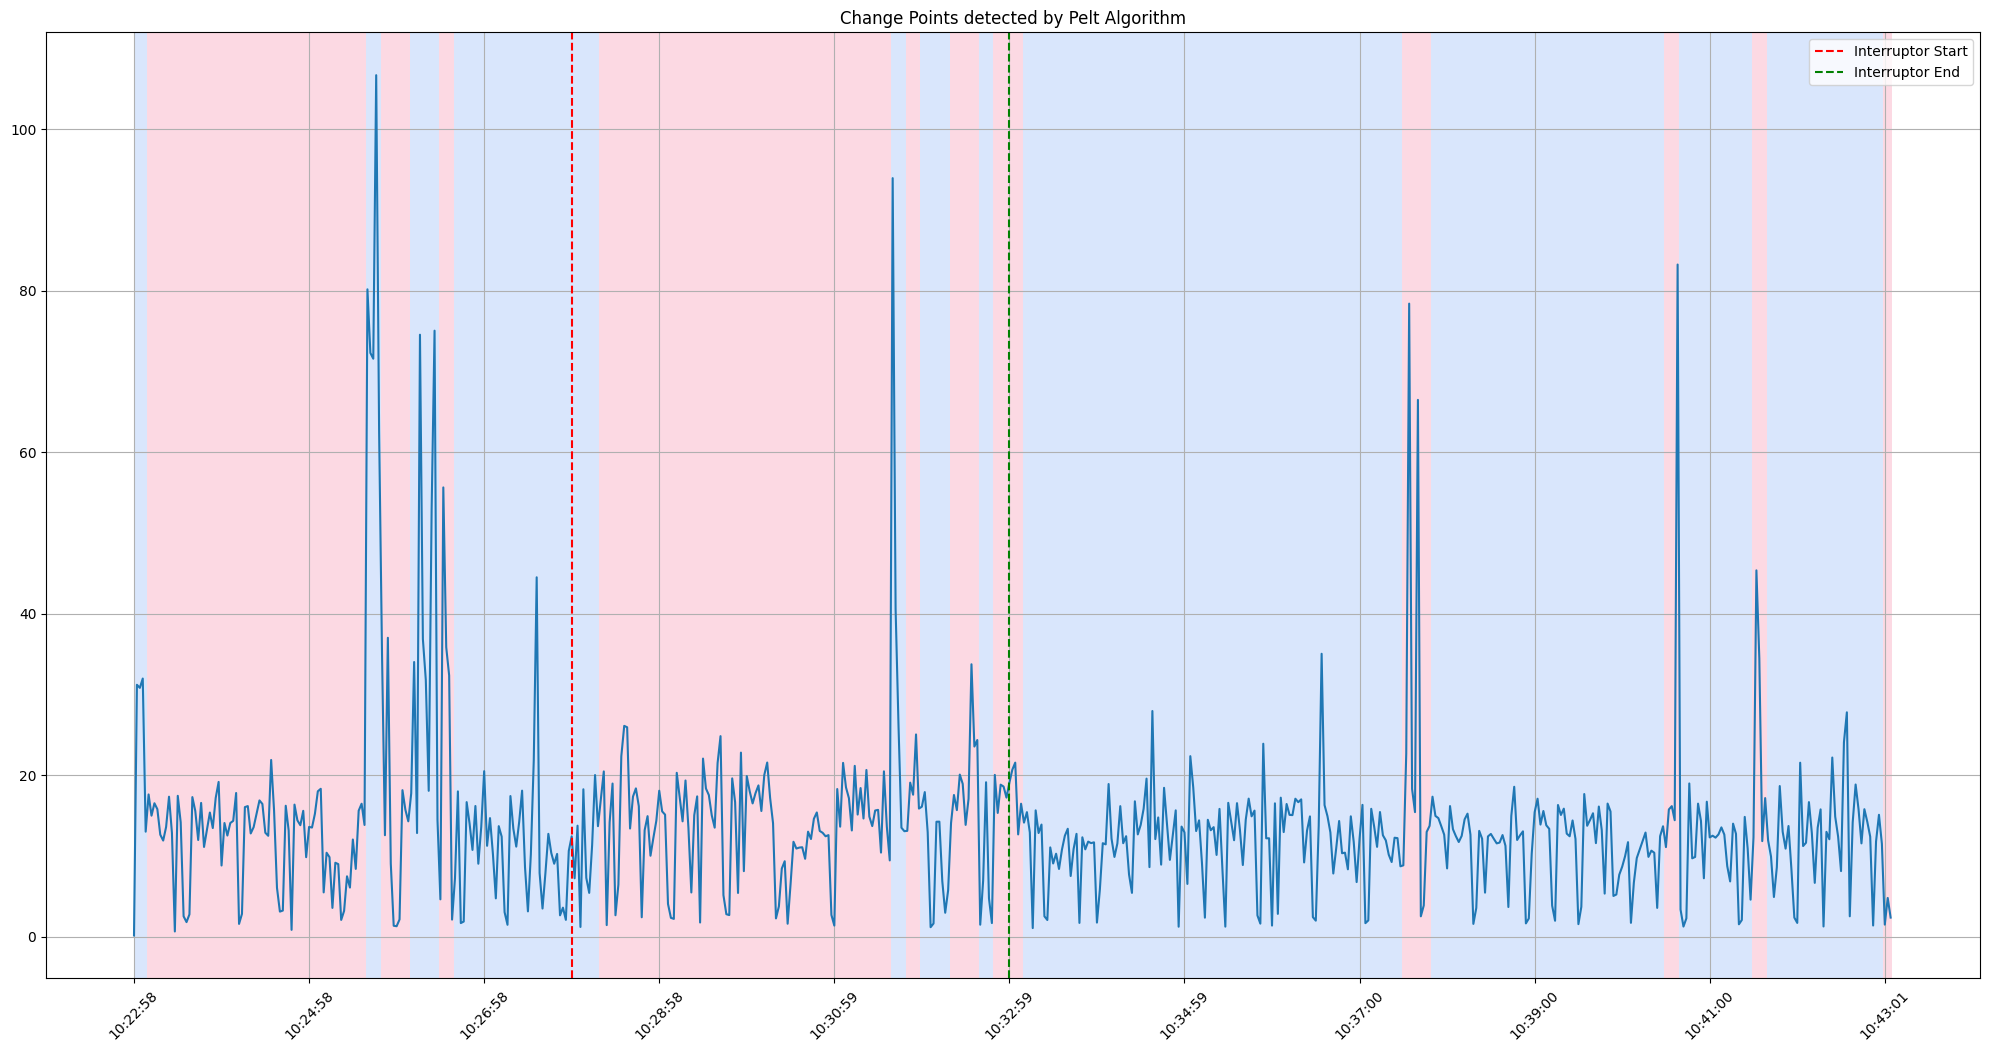

In [95]:
df = pd.read_csv("SYS/docker_container_stats.csv")

df.columns = df.columns.str.strip()

df["CPU Usage (%)"] = df["CPU Usage (%)"].str.rstrip("%")
df["Time"] = pd.to_datetime(df["Time"])

cpu_df = df[["Time", "CPU Usage (%)"]].copy()

time_labels = cpu_df["Time"].dt.strftime("%H:%M:%S").values
indices = np.arange(len(signal))

start_time = cpu_df["Time"].min()
time_5min = start_time + pd.Timedelta(minutes=5)

exact_time_5min = cpu_df.iloc[(cpu_df["Time"] - time_5min).abs().argsort()[:1]]["Time"].values[0]
exact_time_10min = cpu_df.iloc[(cpu_df["Time"] - (start_time + pd.Timedelta(minutes=10))).abs().argsort()[:1]]["Time"].values[0]

cpu_df["CPU Usage (%)"] = cpu_df["CPU Usage (%)"].astype(str).str.rstrip("%")

cpu_df["CPU Usage (%)"] = (cpu_df["CPU Usage (%)"].astype(str).str.rstrip("% ").astype("float"))

signal = cpu_df["CPU Usage (%)"].values

model = "l2"  # "l1", "rbf" # Try with different models and compare results

algo = rpt.Pelt(model=model).fit(signal)

result = algo.predict(pen=210.2)

# Using ruptures display function
rpt.display(signal, result, figsize=(20, 10))

step_size = len(signal) // 10 if len(signal) // 10 > 0 else 1

indices = np.arange(0, len(signal), step_size)
time_labels = cpu_df["Time"].dt.strftime("%H:%M:%S").values[indices]
plt.xticks(ticks=indices, labels=time_labels, rotation=45)
index_5min = cpu_df[cpu_df["Time"] == exact_time_5min].index[0]
index_10min = cpu_df[cpu_df["Time"] == exact_time_10min].index[0]

plt.axvline(x=index_5min, color="r", linestyle="--", label="Interruptor Start")
plt.axvline(x=index_10min, color="g", linestyle="--", label="Interruptor End")

plt.legend()
plt.grid(True)
plt.title("Change Points detected by Pelt Algorithm")
plt.savefig("SYS/Plots/Change_Points_Pelt_Algorithm_CPU.png")
plt.show()

#### DP for memory usage

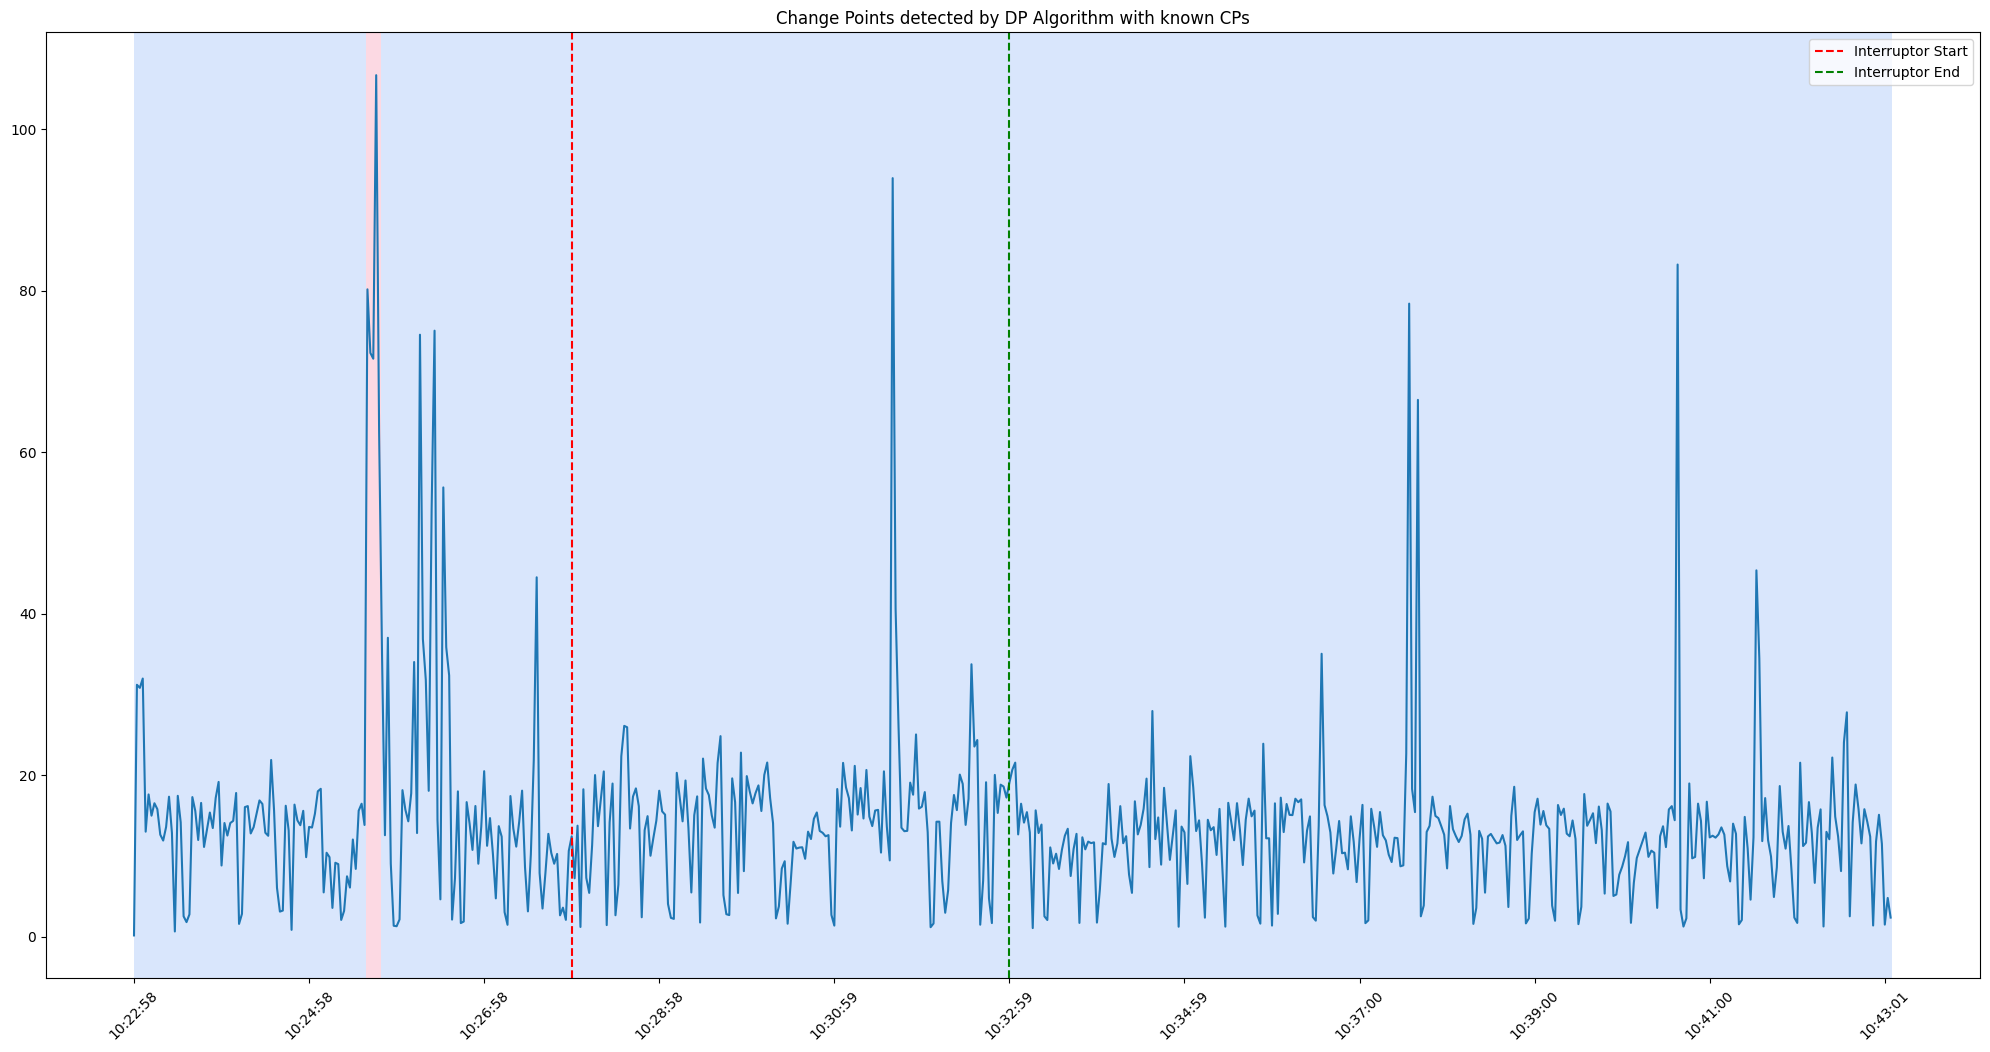

In [93]:
df = pd.read_csv("SYS/docker_container_stats.csv")
df.columns = df.columns.str.strip()

# df["Memory Usage"] = (df["Memory Usage"].str.replace("MiB", "").str.replace("GiB", "").str.strip())
df["Memory Usage"] = df["Memory Usage"].str.split("/").str[0]
df["Memory Usage"] = df["Memory Usage"].apply(lambda x: (pd.to_numeric(x.replace("MiB", "")) / 1024 if "MiB" in x else pd.to_numeric(x.replace("GiB", ""))))

# df["Memory Usage"] = pd.to_numeric(df["Memory Usage"])

df["Time"] = pd.to_datetime(df["Time"], format="%Y-%m-%d %H:%M:%S")

mem_df = df[["Time", "Memory Usage"]].copy()

time_labels = mem_df["Time"].dt.strftime("%H:%M:%S").values
indices = np.arange(len(signal))

start = mem_df["Time"].min()
time_5 = start + pd.Timedelta(minutes=5)
time_10 = start + pd.Timedelta(minutes=10)

exact_time_5min = mem_df.iloc[(mem_df["Time"] - time_5).abs().argsort()[:1]].iloc[0]["Time"]
exact_time_10min = mem_df.iloc[(mem_df["Time"] - time_10).abs().argsort()[:1]].iloc[0]["Time"]
model = "l2"  # "l1", "rbf" # Try with different models and compare results

algo = rpt.Dynp(model=model, min_size=1, jump=5).fit(signal)
result = algo.predict(n_bkps=2)

rpt.display(signal, result, figsize=(20, 10))
step_size = len(signal) // 10 if len(signal) // 10 > 0 else 1

indices = np.arange(0, len(signal), step_size)
time_labels = mem_df["Time"].dt.strftime("%H:%M:%S").values[indices]
plt.xticks(ticks=indices, labels=time_labels, rotation=45)
index_5min = mem_df[mem_df["Time"] == exact_time_5min].index[0]
index_10min = mem_df[mem_df["Time"] == exact_time_10min].index[0]

plt.axvline(x=index_5min, color="r", linestyle="--", label="Interruptor Start")
plt.axvline(x=index_10min, color="g", linestyle="--", label="Interruptor End")

plt.legend()
plt.title("Change Points detected by DP Algorithm with known CPs")
plt.savefig("SYS/Plots/Change_Points_DP_Algorithm_Mem.png")
plt.show()

#### DP for cpu usage

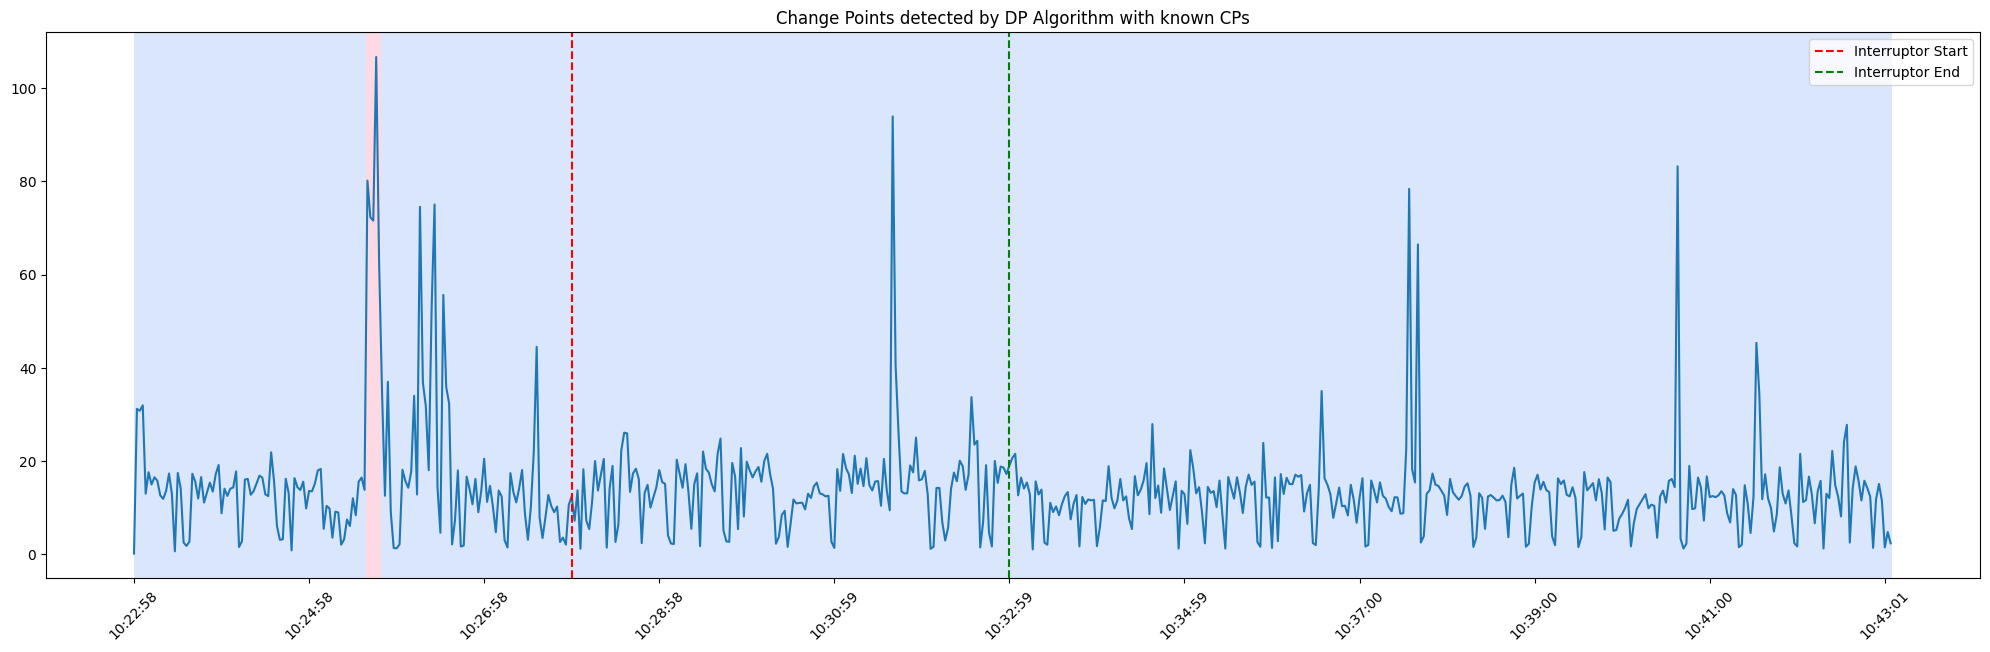

In [92]:
df = pd.read_csv("SYS/docker_container_stats.csv")

df.columns = df.columns.str.strip()

df["CPU Usage (%)"] = df["CPU Usage (%)"].str.rstrip("%")
df["Time"] = pd.to_datetime(df["Time"])

cpu_df = df[["Time", "CPU Usage (%)"]].copy()

time_labels = cpu_df["Time"].dt.strftime("%H:%M:%S").values
indices = np.arange(len(signal))

start_time = cpu_df["Time"].min()
time_5min = start_time + pd.Timedelta(minutes=5)

exact_time_5min = cpu_df.iloc[(cpu_df["Time"] - time_5min).abs().argsort()[:1]]["Time"].values[0]
exact_time_10min = cpu_df.iloc[(cpu_df["Time"] - (start_time + pd.Timedelta(minutes=10))).abs().argsort()[:1]]["Time"].values[0]

cpu_df["CPU Usage (%)"] = cpu_df["CPU Usage (%)"].astype(str).str.rstrip("%")

cpu_df["CPU Usage (%)"] = (cpu_df["CPU Usage (%)"].astype(str).str.rstrip("% ").astype("float"))

signal = cpu_df["CPU Usage (%)"].values

model = "l1"  # "l1", "rbf" # Try with different models and compare results

algo = rpt.Dynp(model=model, min_size=1, jump=5).fit(signal)

result = algo.predict(n_bkps=2)

rpt.display(signal, result, figsize=(20, 6))

step_size = len(signal) // 10 if len(signal) // 10 > 0 else 1

indices = np.arange(0, len(signal), step_size)
time_labels = cpu_df["Time"].dt.strftime("%H:%M:%S").values[indices]
plt.xticks(ticks=indices, labels=time_labels, rotation=45)
index_5min = cpu_df[mem_df["Time"] == exact_time_5min].index[0]
index_10min = cpu_df[mem_df["Time"] == exact_time_10min].index[0]

plt.axvline(x=index_5min, color="r", linestyle="--", label="Interruptor Start")
plt.axvline(x=index_10min, color="g", linestyle="--", label="Interruptor End")

plt.legend()
plt.title("Change Points detected by DP Algorithm with known CPs")
plt.savefig("SYS/Plots/Change_Points_DP_Algorithm_CPU.png")
plt.show()

# Metric: Transaction counts (#) 

## Formatting

#### Extract log

In [175]:
log_file_path = "TRT/filtered_transaction_data.log"

log_file_path = "TRT/filtered_transaction_data.log"
output_file_path = "TC/transaction_counts.log"
match_term = "TRANSACTION COUNT"

with open(log_file_path, "r") as file:
    lines = file.readlines()

# Find the index of the line that matches the term
match_index = next((index for index, line in enumerate(lines) if match_term in line), None)

if match_index is not None:
    # Write the lines from the match index to the end of the file to the output file
    with open(output_file_path, "w") as output_file:
            
        output_file.writelines(lines[match_index:])
        
else:
    print("Match term not found in the log file.")

    

#### CSV

In [5]:
# Filter the log file to remove unnecessary lines
counter_pattern = r'"(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2})": "(\d+)",'

log_file = "TC/transaction_counts.log"
output_file_path = "TC/transaction_counts.csv"

with open(log_file, "r") as file, open(output_file_path, "w") as output_file:

    output_file.write("Timestamp,Transaction_Count\n")

    for line in file:
        if re.match(counter_pattern, line.strip()):
            line = line.replace('"', '')
            count_colon = 0
            count_comma = 0
            new_line = ''
            for i in range(len(line)):
                if line[i] == ':':
                    count_colon += 1
                    if count_colon % 3 == 0:
                        new_line += ','  
                    else:
                        new_line += line[i]
                elif line[i] == ',':
                    count_comma += 1
                    if count_comma % 2 != 0:
                        new_line += line[i]
                else:
                    new_line += line[i]
            new_line = new_line.replace(', ', ',')  
            output_file.write(new_line)

## Preprocessing

#### Transaction counts (#)

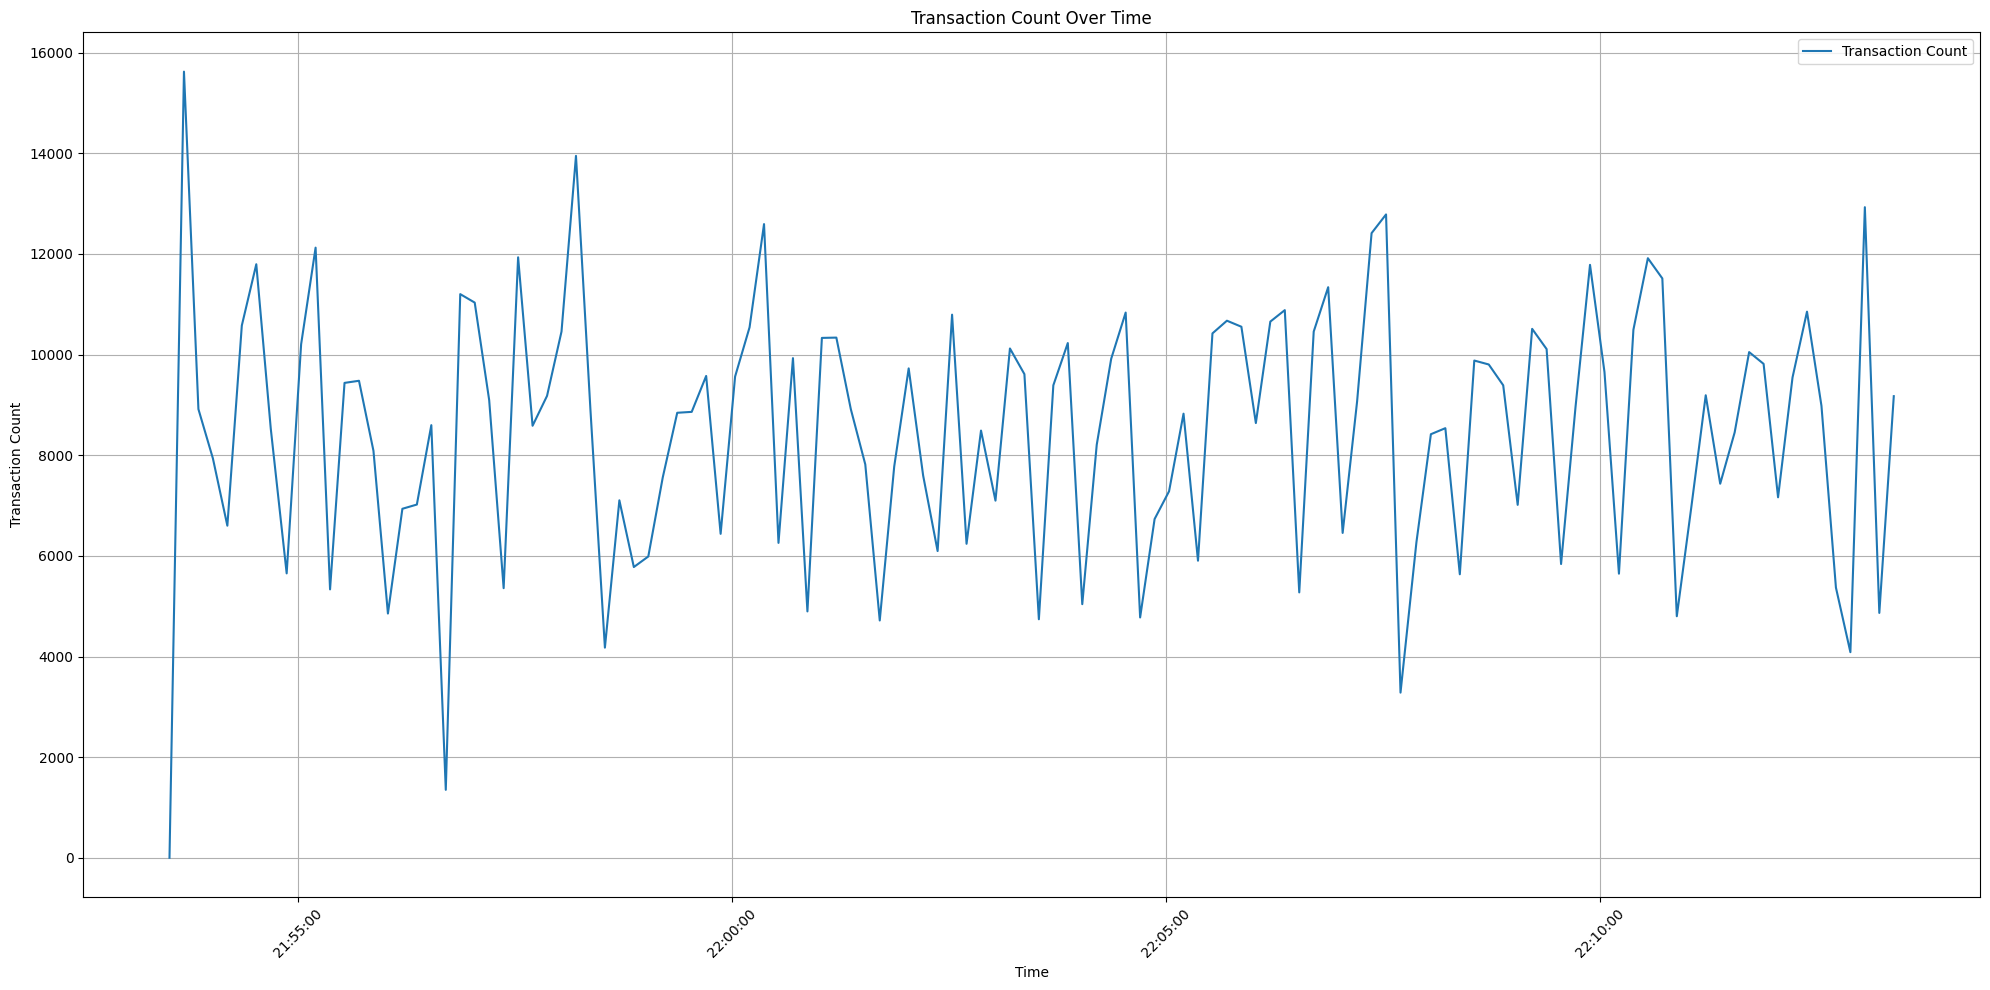

In [103]:
df = pd.read_csv("TC/transaction_counts.csv", usecols=[0, 1])
df.columns = df.columns.str.strip()
df["Timestamp"] = df["Timestamp"].str.strip()
df["Timestamp"] = pd.to_datetime(df["Timestamp"], format="%Y-%m-%d %H:%M:%S")

#print(df.head(5))

plt.figure(figsize=(20, 10))

plt.plot(df['Timestamp'], df['Transaction_Count'], label="Transaction Count", linestyle="-")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))

plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.xticks(rotation=45)

plt.xlabel("Time")

plt.ylabel("Transaction Count")

plt.title("Transaction Count Over Time")

plt.grid(True)

plt.tight_layout()  

plt.legend()
plt.savefig("TC/Plots/Transaction_Count_Over_Time.png")
plt.show()

## CPD

#### Pelt

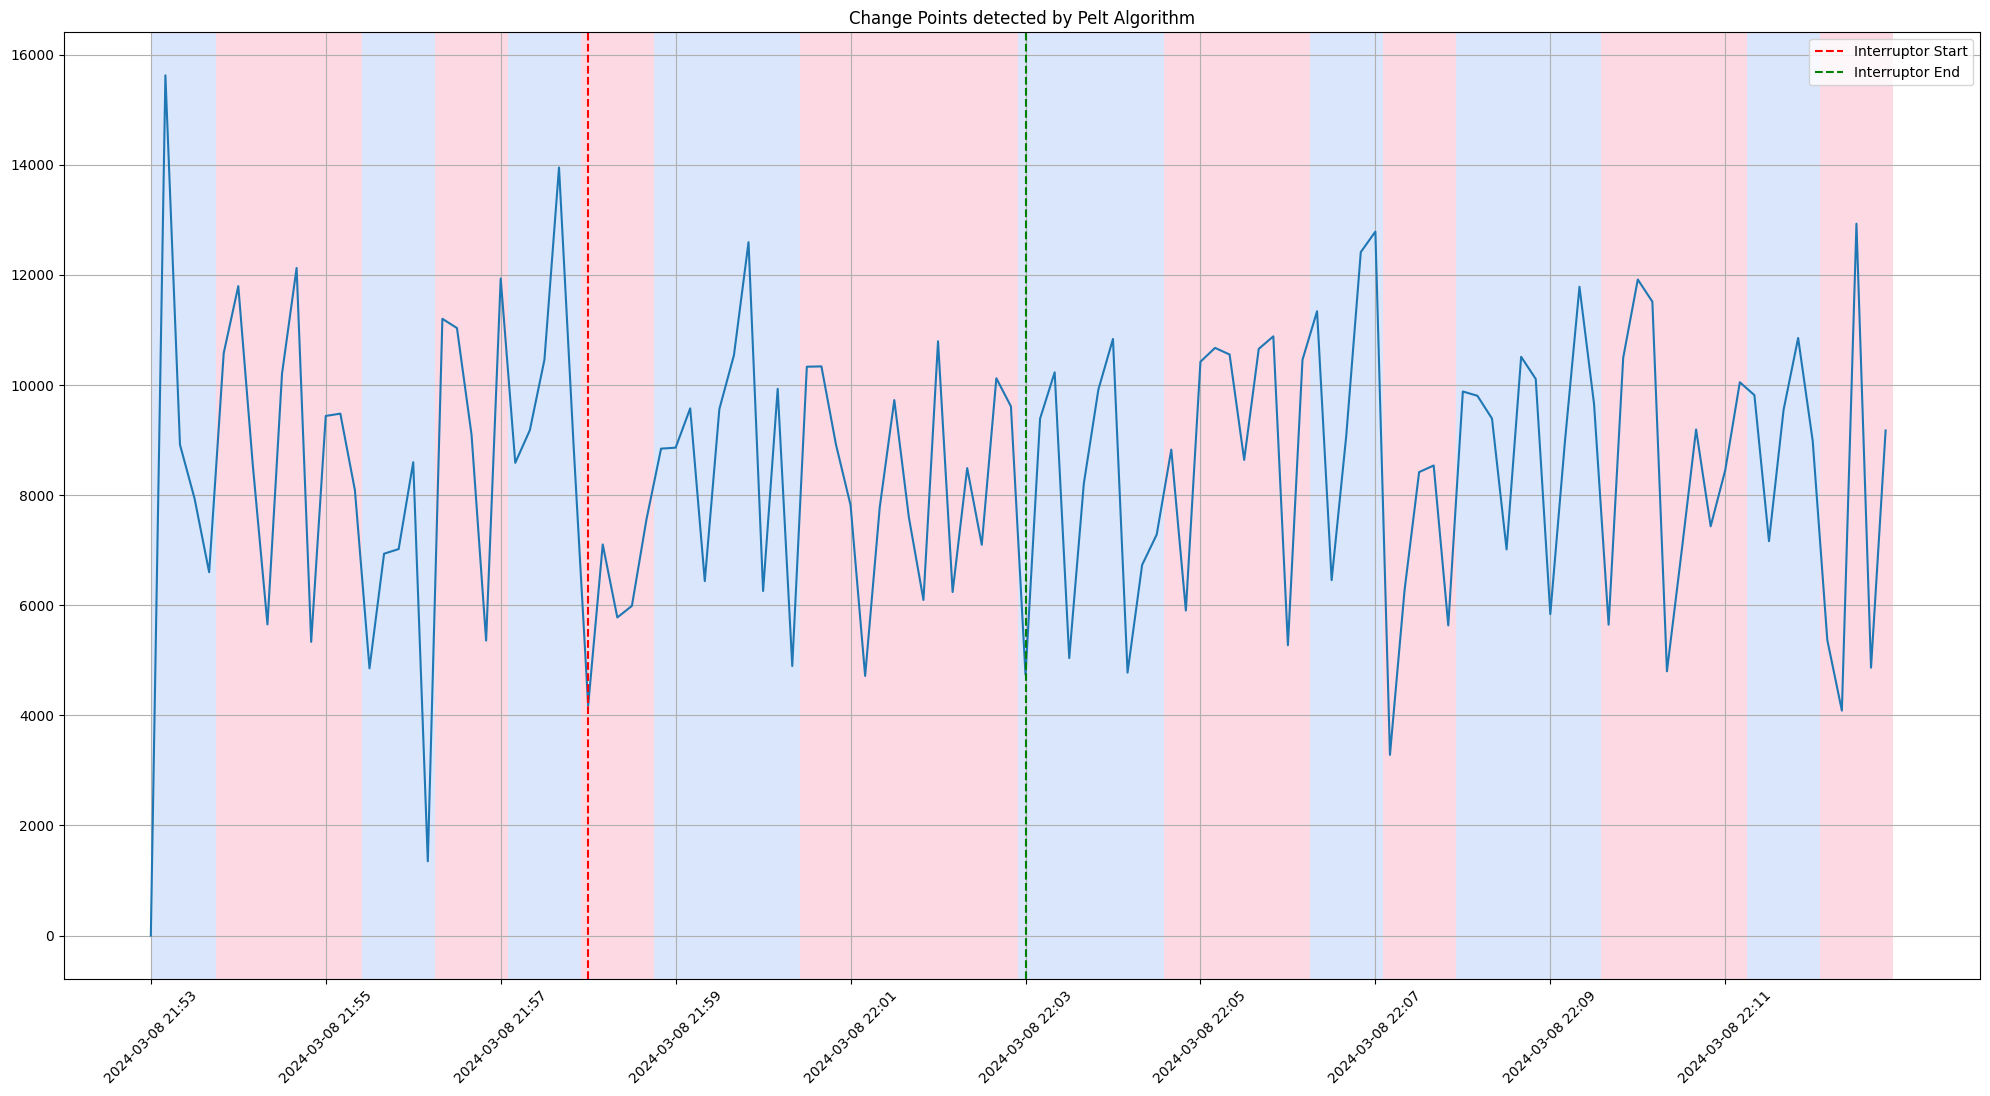

In [101]:
df = pd.read_csv("TC/transaction_counts.csv", usecols=[0, 1])
df.columns = df.columns.str.strip()
df["Timestamp"] = df["Timestamp"].str.strip()
df["Timestamp"] = pd.to_datetime(df["Timestamp"], format="%Y-%m-%d %H:%M:%S")

time_labels = df["Timestamp"].values
indices = np.arange(len(signal))

start_time = df["Timestamp"].min()
exact_time_5min = df.iloc[(df["Timestamp"] - (start_time + pd.Timedelta(minutes=5))).abs().argsort()[:1]]["Timestamp"].values[0]
exact_time_10min = df.iloc[(df["Timestamp"] - (start_time + pd.Timedelta(minutes=10))).abs().argsort()[:1]]["Timestamp"].values[0]

signal = df["Transaction_Count"].values

model = "l2"  # "l1", "rbf" # Try with different models and compare results

algo = rpt.Pelt(model=model).fit(signal)

result = algo.predict(pen=570000)

# Using ruptures display function
rpt.display(signal, result, figsize=(20, 10))

step_size = len(signal) // 10 if len(signal) // 10 > 0 else 1
indices = np.arange(0, len(signal), step_size)
time_labels = df["Timestamp"].values[indices]
plt.xticks(ticks=indices, labels=time_labels, rotation=45)
index_5min = df[df["Timestamp"] == exact_time_5min].index[0]
index_10min = df[df["Timestamp"] == exact_time_10min].index[0]

plt.axvline(x=index_5min, color="r", linestyle="--", label="Interruptor Start")
plt.axvline(x=index_10min, color="g", linestyle="--", label="Interruptor End")

plt.legend()
plt.title("Change Points detected by Pelt Algorithm")
formatted_labels = [pd.to_datetime(label).strftime("%Y-%m-%d %H:%M") for label in time_labels]
plt.xticks(ticks=indices, labels=formatted_labels, rotation=45)
plt.grid(True)
plt.savefig("TC/Plots/Change_Points_Pelt_Algorithm_TC.png")
plt.show()

#### DP

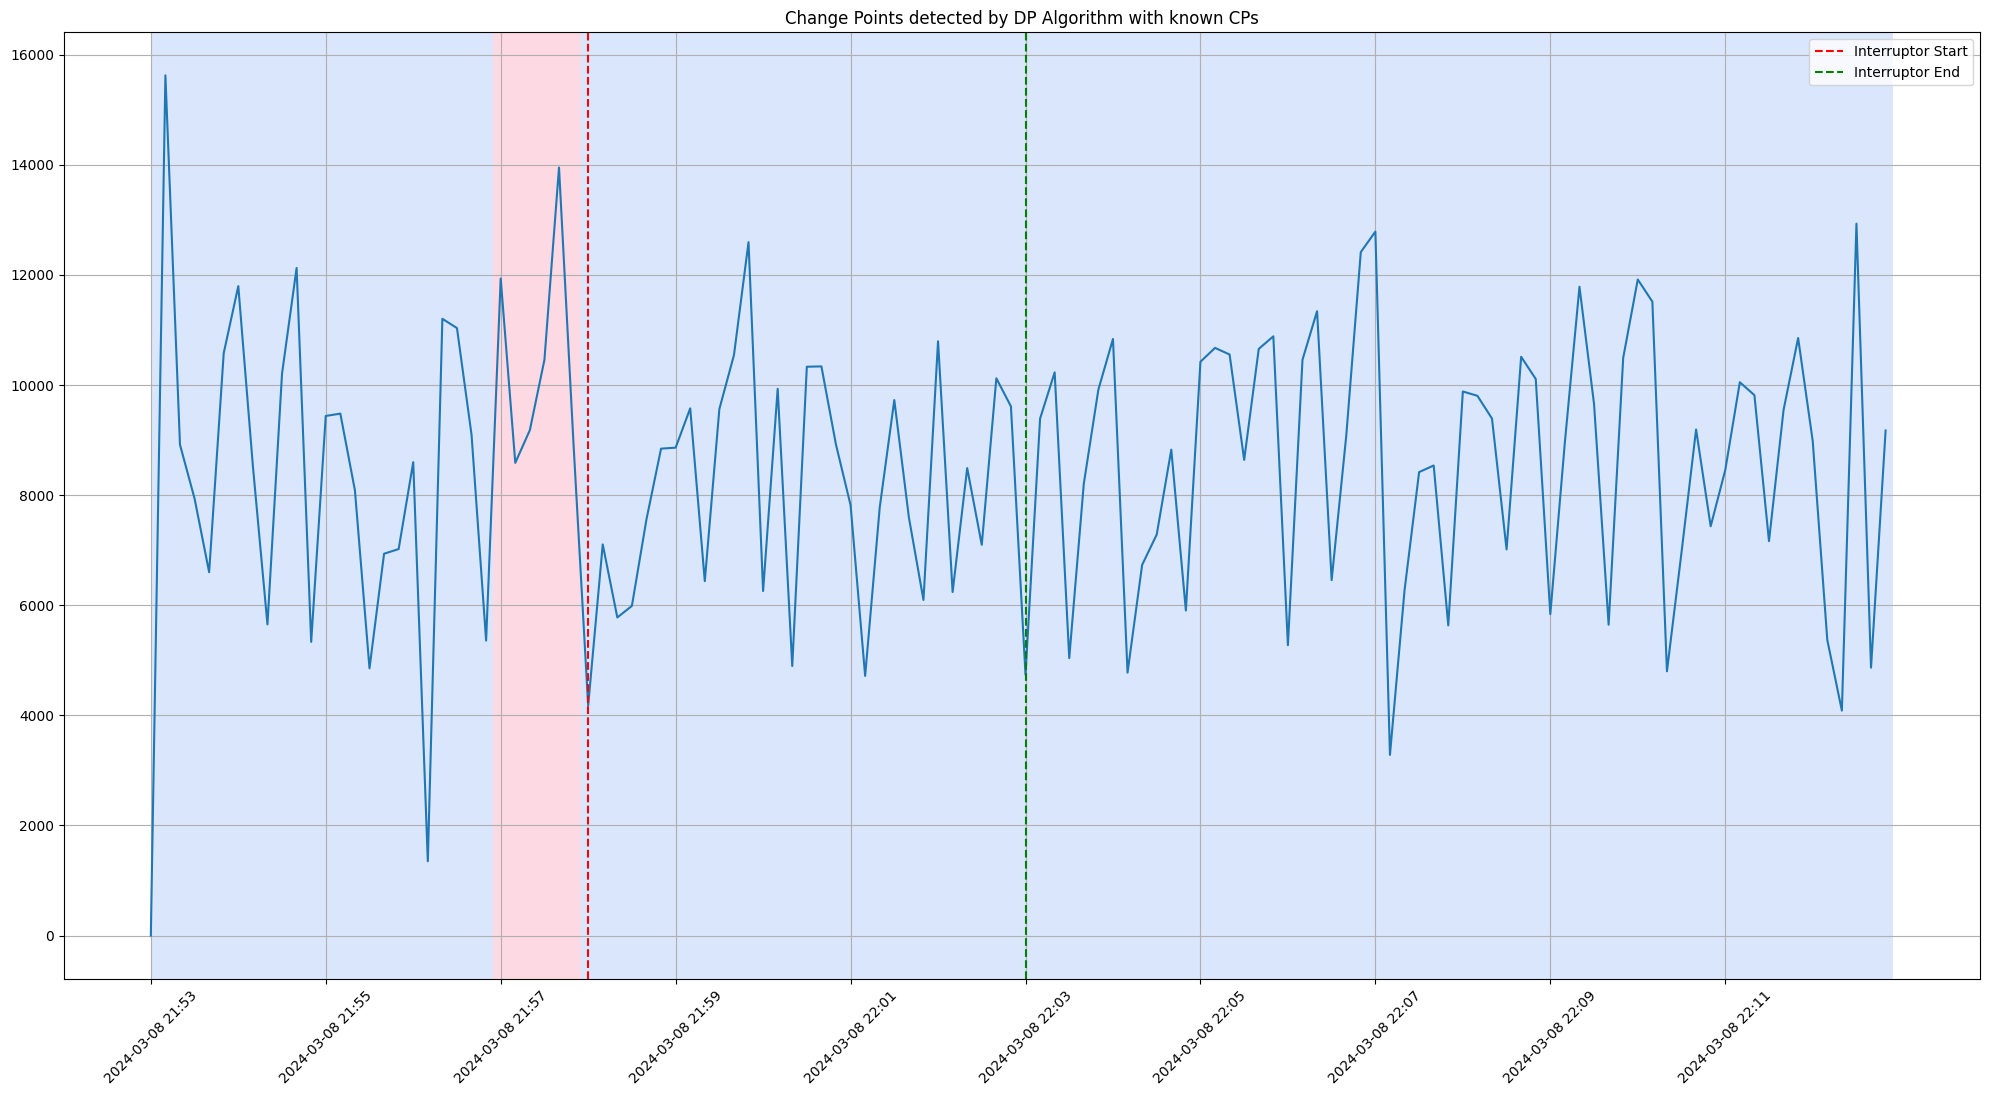

In [98]:
df = pd.read_csv("TC/transaction_counts.csv", usecols=[0, 1])
df.columns = df.columns.str.strip()
df["Timestamp"] = df["Timestamp"].str.strip()
df["Timestamp"] = pd.to_datetime(df["Timestamp"], format="%Y-%m-%d %H:%M:%S")

time_labels = df["Timestamp"].values
indices = np.arange(len(signal))

start_time = df["Timestamp"].min()
exact_time_5min = df.iloc[(df["Timestamp"] - (start_time + pd.Timedelta(minutes=5))).abs().argsort()[:1]]["Timestamp"].values[0]
exact_time_10min = df.iloc[(df["Timestamp"] - (start_time + pd.Timedelta(minutes=10))).abs().argsort()[:1]]["Timestamp"].values[0]

signal = df["Transaction_Count"].values

model = "l2"
algo = rpt.Dynp(model=model, min_size=3, jump=3).fit(signal)
result = algo.predict(n_bkps=2)

rpt.display(signal, result, figsize=(20, 10))

step_size = len(signal) // 10 if len(signal) // 10 > 0 else 1
indices = np.arange(0, len(signal), step_size)

time_labels = df["Timestamp"].values[indices]
plt.xticks(ticks=indices, labels=time_labels, rotation=45)
index_5min = df[df["Timestamp"] == exact_time_5min].index[0]
index_10min = df[df["Timestamp"] == exact_time_10min].index[0]

plt.axvline(x=index_5min, color="r", linestyle="--", label="Interruptor Start")
plt.axvline(x=index_10min, color="g", linestyle="--", label="Interruptor End")

plt.legend()
formatted_labels = [pd.to_datetime(label).strftime("%Y-%m-%d %H:%M") for label in time_labels]
plt.xticks(ticks=indices, labels=formatted_labels, rotation=45)
plt.grid(True)
plt.title("Change Points detected by DP Algorithm with known CPs")
plt.savefig("TC/Plots/Change_Points_DP_Algorithm_TC.png")
plt.show()
